In [1]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt

import pmdarima as pm
from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
def smape(actual, predicted) -> float:  
    temporary_smape_nominator = np.abs(np.array(actual) - np.array(predicted))
    temporary_smape_denominator = [np.max(elem) for elem in list(zip(predicted, actual))]

    return float(np.sum(temporary_smape_nominator) / np.sum(temporary_smape_denominator))

def regression_insights(actual, predicted) -> tuple: 
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    return mse, rmse, mae, r2

def bias(actual, predicted) -> float:
    return float(np.sum(np.abs(1 - np.array(predicted) / np.array(actual + 0.00000001))))

In [3]:
biggest_garage = pd.read_csv("../podaci/vremenske-serije/najveca_garaza_date_value.csv")
biggest_garage

,date,counts
0,2019-12-20,0.443902
1,2019-12-23,0.887805
2,2019-12-27,0.443902
3,2020-01-08,0.443902
4,2020-01-13,0.443902
...,...,...
268,2021-05-25,1.331707
269,2021-05-26,1.331707
270,2021-05-27,1.775610
271,2021-05-31,0.443902


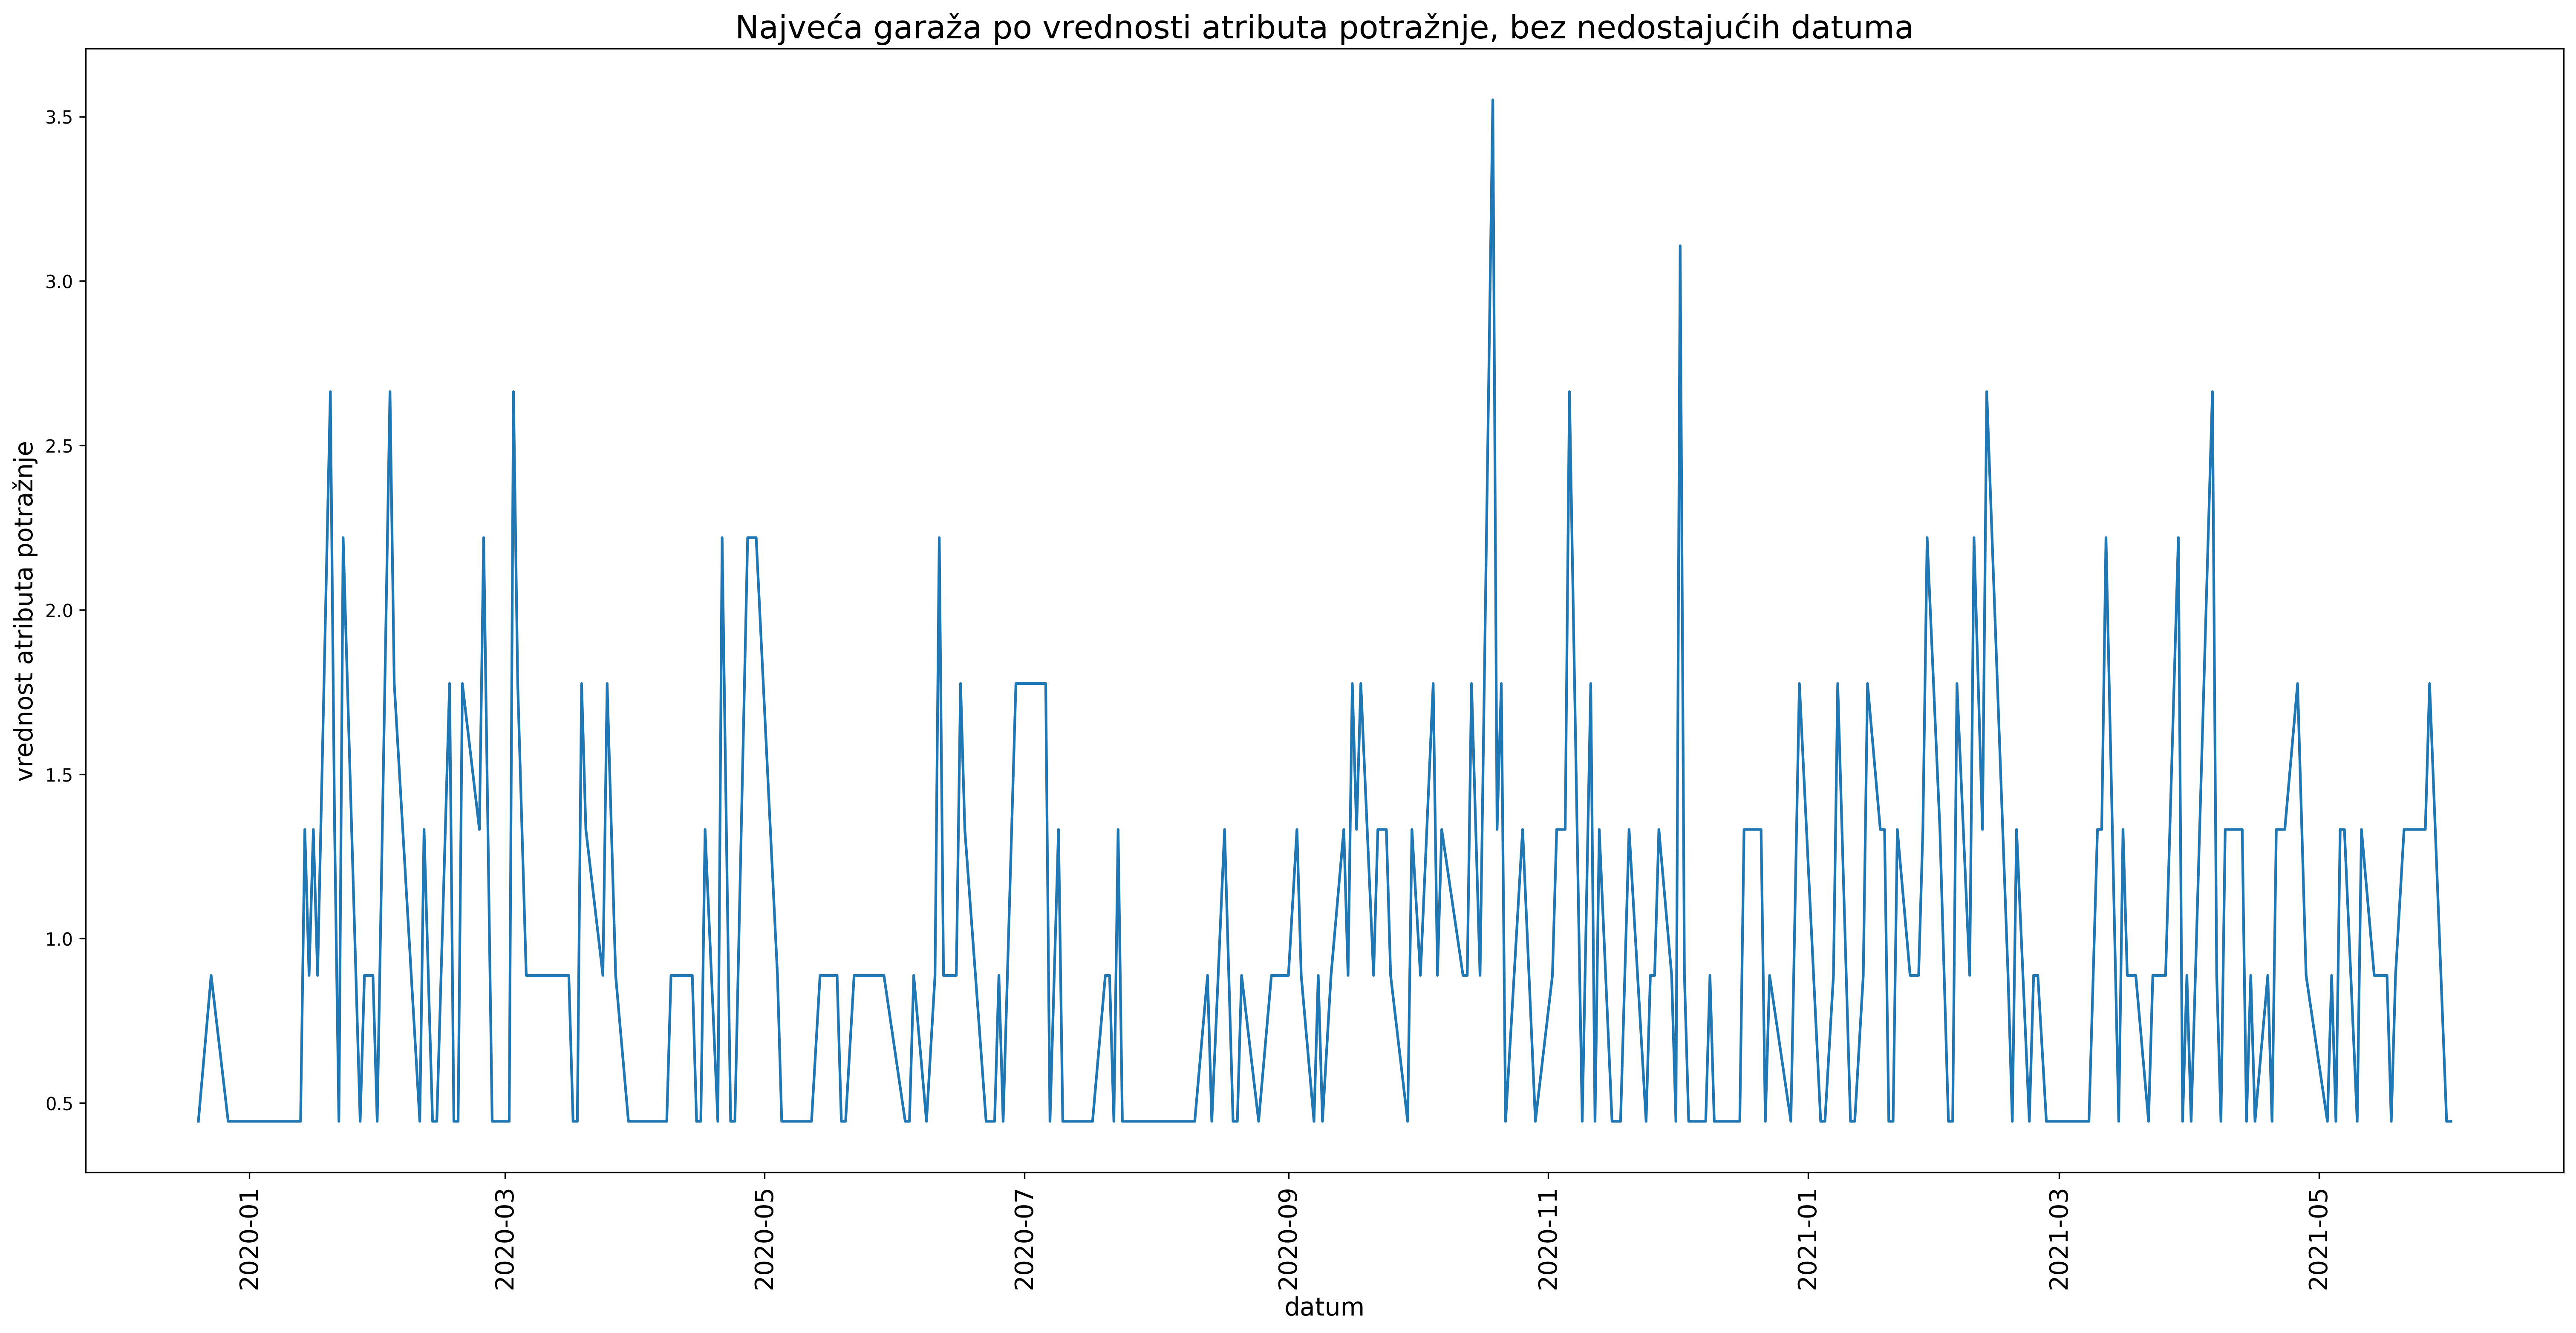

In [4]:
plt.figure(figsize=(20, 10), dpi=300)
tmp_df = biggest_garage
tmp_df = tmp_df.astype({'date': 'datetime64[ns]'})
plt.plot(tmp_df['date'], tmp_df['counts'])
plt.xticks(fontsize=14, rotation="vertical")
plt.tight_layout()
plt.title("Najveća garaža po vrednosti atributa potražnje, bez nedostajućih datuma", fontsize=18)
plt.xlabel("datum", fontsize=14)
plt.ylabel("vrednost atributa potražnje", fontsize=14)
plt.show()

In [5]:
tmp_df.dtypes

date      datetime64[ns]
counts           float64
dtype: object

In [6]:
top_garage = tmp_df.copy()
top_garage = top_garage.astype({'date': 'datetime64[ns]'})

# 1. koji range imamo:
min_date = top_garage['date'].min()
max_date = top_garage['date'].max()
top_garage.set_index('date', inplace=True)

date_range = pd.date_range(min_date, max_date, freq='D')

# 2. left-join na date_range sa našim datumima
date_range_series = pd.Series(index=date_range, dtype='int64')
top_garage_filled = pd.concat([top_garage,
                               date_range_series[~date_range_series.index.isin(top_garage.index)]]).sort_index()

top_garage_filled = top_garage_filled.drop([0], axis=1).fillna(0).astype({'counts': 'float32'})
top_garage_filled['date'] = top_garage_filled.index
top_garage_filled.reset_index(drop=True, inplace=True)
top_garage_filled.head(5)


,counts,date
0,0.443902,2019-12-20
1,0.000000,2019-12-21
2,0.000000,2019-12-22
3,0.887805,2019-12-23
4,0.000000,2019-12-24


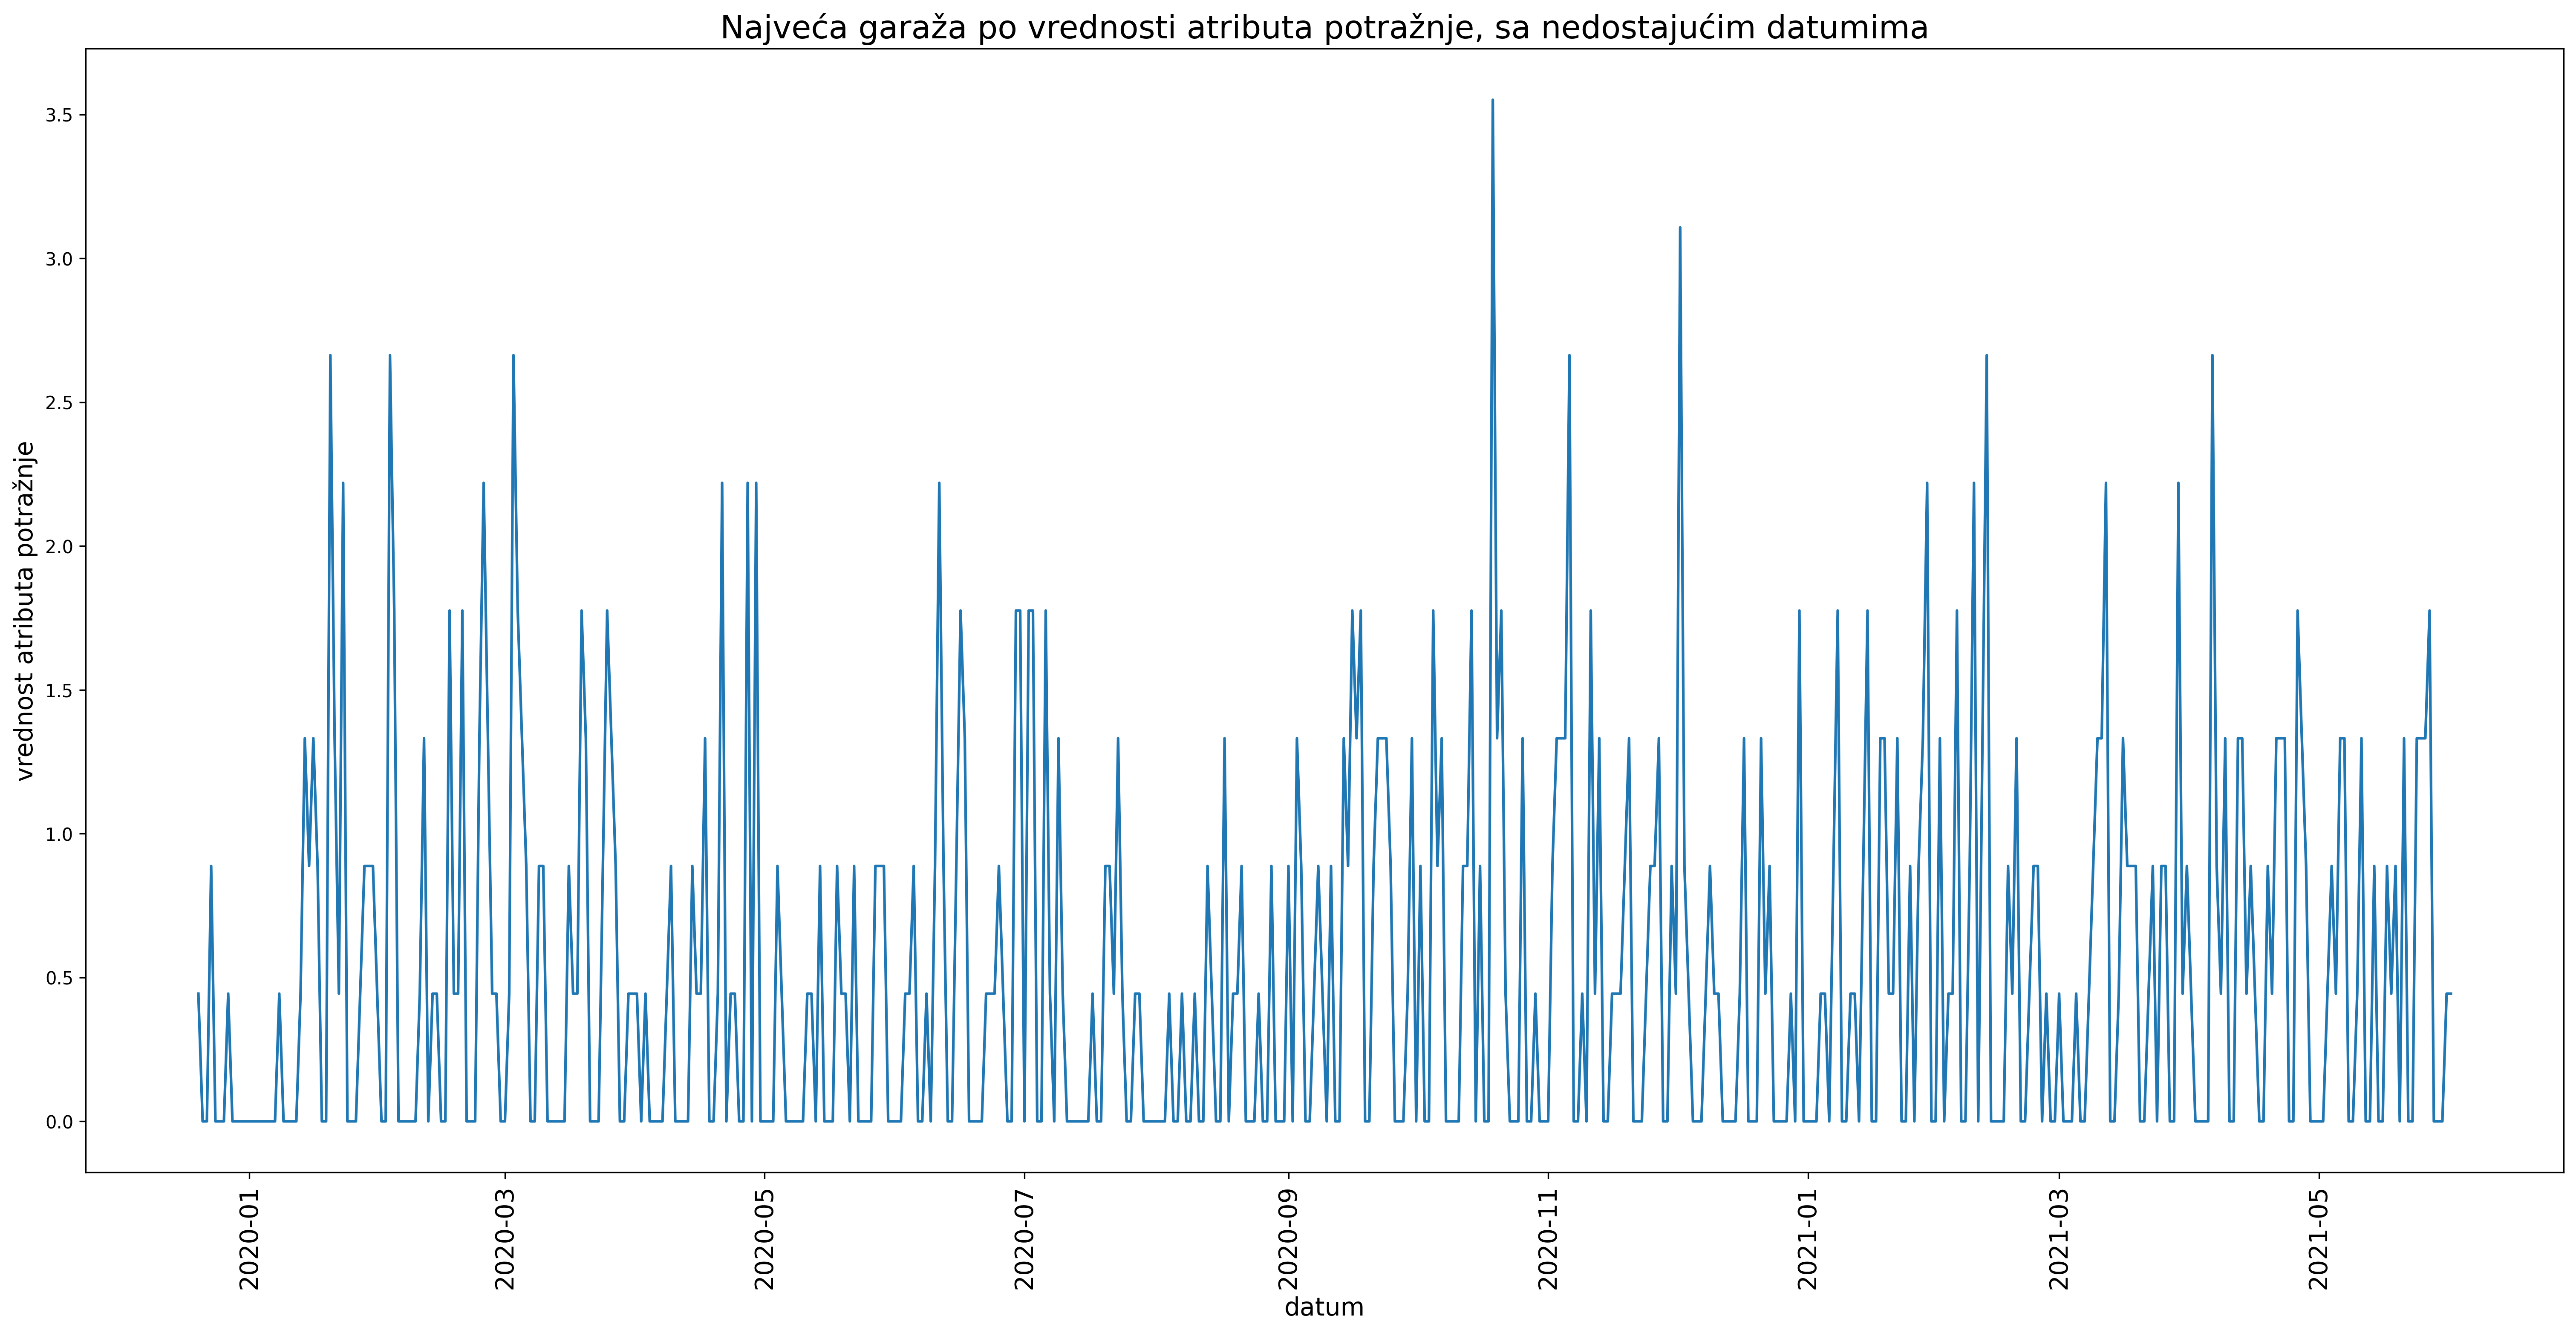

In [7]:
plt.figure(figsize=(20, 10), dpi=300)
plt.plot(top_garage_filled['date'], top_garage_filled['counts'])
plt.xticks(fontsize=14, rotation="vertical")
plt.tight_layout()
plt.title("Najveća garaža po vrednosti atributa potražnje, sa nedostajućim datumima", fontsize=18)
plt.xlabel("datum", fontsize=14)
plt.ylabel("vrednost atributa potražnje", fontsize=14)

plt.show()

In [8]:
# pick the medium one and see
# try with 0 to plot
# volatility 
# make it stationary?
# do the auto-arima on this one! 

top_garage_filled = top_garage_filled.rename(columns={"counts": "demand_value"})

auto_model = pm.auto_arima(top_garage_filled['demand_value'], 
                            stepwise=True, 
                            approximation=False
                           )
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  530
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -518.591
Date:                Sat, 17 Jul 2021   AIC                           1043.181
Time:                        14:56:05   BIC                           1056.000
Sample:                             0   HQIC                          1048.199
                                - 530                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5151      0.048     10.685      0.000       0.421       0.610
ma.L1          0.1965      0.045      4.362      0.000       0.108       0.285
sigma2         0.4144      0.026     15.877      0.000       0.363       0.466
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               245.89
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             1.36
Prob(H) (two-sided):                  0.97   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
def plot_timeseries(data, column="demand_value", granularity="dani"):
    size_df = len(data[column])
    
    plt.rcParams.update({'figure.figsize':(11, 5), 'figure.dpi':90})
    
    plt.plot(data[column], 
             label="original")
    plt.plot(np.arange(0, size_df, 1), 
             np.repeat(np.mean(data[column]), size_df),
             label="srednja vrednost")
    
    plt.title("Vrednost atributa potražnje tokom vremena")
    plt.xlabel(f"{granularity}")
    plt.ylabel("broj rezervacija")
    plt.legend()
    
def auto_diffs(df, target="demand_value", test="adf"):
    print(f'Originalni podaci diff d: {pm.arima.utils.ndiffs(df[target], test=test, max_d=3)}')
    print(f'Originalni podaci diff D: {pm.arima.utils.nsdiffs(df[target], m=365, max_D=10)}')


def probplot(df, target="demand_value"):
    plt.rcParams.update({'figure.figsize':(8, 7), 'figure.dpi':90})
    fig = plt.figure()

    ax1 = fig.add_subplot(411)
    prob = stats.probplot(df[target], dist='norm', plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot u odnosu na normalnu distribuciju')

    ax2 = fig.add_subplot(412)
    prob = stats.probplot(df[target].diff().dropna(), dist='norm', plot=ax2)
    ax2.set_xlabel('')
    ax2.set_title('Probplot za jednom diferencirane (y(t) - y(t-1)) originalne podatke')

    ax3 = fig.add_subplot(413)
    prob = stats.probplot(df[target].diff().diff().dropna(), dist='norm', plot=ax3)
    ax3.set_xlabel('')
    ax3.set_title('Probplot za 2 puta diferencirane originalne podatke')

    ax4 = fig.add_subplot(414)
    prob = stats.probplot(df[target].diff().diff().diff().dropna(), dist='norm', plot=ax4)
    ax4.set_title('Probplot za 3 puta diferencirane originalne podatke')

    plt.tight_layout()
    plt.show()

def plot_acf_pacf(df, diff_period=6, target="demand_value", lags_acf=40, lags_pacf=20):
    plt.rcParams.update({'figure.figsize':(12, 10), 'figure.dpi':90})

    fig, axs = plt.subplots(5, 2)

    plot_acf(df[target], ax=axs[0, 0], lags=lags_acf, alpha=0.05)
    axs[0, 0].set_title("Originalni podaci ACF")
    plot_acf(df[target].diff().dropna(), ax=axs[1, 0], lags=lags_acf, alpha=0.05)
    axs[1, 0].set_title("1 diff() originalni podaci ACF")
    plot_acf(df[target].diff().diff().dropna(), ax=axs[2, 0], lags=lags_acf, alpha=0.05)
    axs[2, 0].set_title("2 diff().diff() originalni podaci ACF")
    plot_acf(df[target].diff(periods=diff_period).dropna(), ax=axs[3, 0], lags=lags_acf, alpha=0.05)
    axs[3, 0].set_title(f"diff(periods={diff_period}) originalni podaci ACF")
    plot_acf(df[target].diff(periods=diff_period).diff(periods=diff_period).dropna(), ax=axs[4, 0], lags=lags_acf, alpha=0.05)
    axs[4, 0].set_title(f"diff(periods={diff_period}).diff(periods={diff_period}) originalni podaci ACF")

    plot_pacf(df[target], ax=axs[0, 1], lags=lags_pacf, alpha=0.05)
    axs[0, 1].set_title("Originalni podaci PACF")
    plot_pacf(df[target].diff().dropna(), ax=axs[1, 1], lags=lags_pacf, alpha=0.05)
    axs[1, 1].set_title("1 diff() originalni podaci PACF")
    plot_pacf(df[target].diff().diff().dropna(), ax=axs[2, 1], lags=lags_pacf, alpha=0.05)
    axs[2, 1].set_title("2 diff().diff() originalni podaci PACF")
    plot_pacf(df[target].diff(periods=diff_period).dropna(), ax=axs[3, 1], lags=lags_pacf, alpha=0.05)
    axs[3, 1].set_title(f"diff(periods={diff_period}) originalni podaci PACF")
    plot_pacf(df[target].diff(periods=diff_period).diff(periods=diff_period).dropna(), ax=axs[4, 1], lags=lags_pacf, alpha=0.05)
    axs[4, 1].set_title(f"diff(periods={diff_period}).diff(periods={diff_period}) originalni podaci PACF")

    plt.tight_layout()
    plt.show()

def test_stationarity(timeseries, rolling_param=14):
    rolmean = timeseries.rolling(rolling_param).mean()
    rolstd = timeseries.rolling(rolling_param).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Kotrljajuća srednja vrednost')
    plt.plot(rolstd, color='black', label = 'Kotrljajuća standardna devijacija')
    plt.legend(loc='best')
    plt.title('Kotrljajuća srednja vrednost i standardna devijacija')
    plt.show(block=False)

    print("Rezultati Dickey-Fuller Testa")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4],
                       index=['Test Statistics',
                              'p-value',
                              'No. of lags used',
                              'Number of observations used'])
    
    for key, values in adft[4].items():
        output['critical value (%s)' % key] =  values
    print(output)

def auto_arima(df, target="demand_value", m=6):
    auto_model = pm.auto_arima(df[target], 
                               start_p=0,
                               start_q=0, 
                               max_p=5,
                               max_q=5, 
                               d=0, 
                               D=0, 
                               start_P=0,
                               start_Q=0, 
                               max_P=5, 
                               max_Q=5, 
                               m=m, 
                               stepwise=True, 
                               approximation=False,
                               seasonal=True)
#     auto_model.summary() 
  
    return auto_model

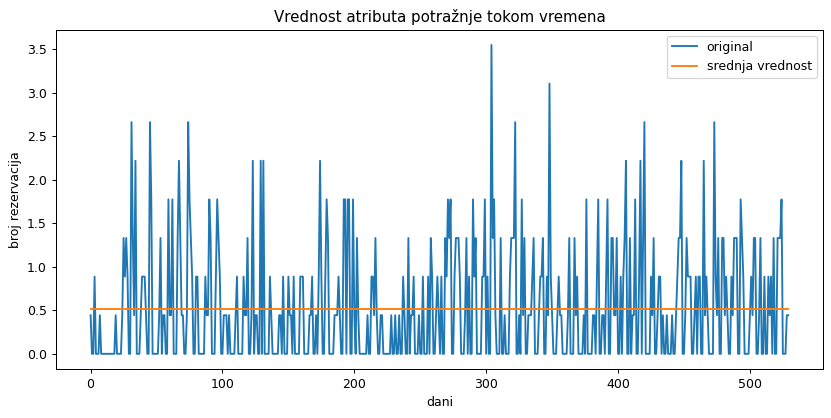

In [10]:
plot_timeseries(top_garage_filled)

In [11]:
auto_diffs(top_garage_filled)

Originalni podaci diff d: 0
Originalni podaci diff D: 0


In [12]:
# probplot(top_garage_filled)

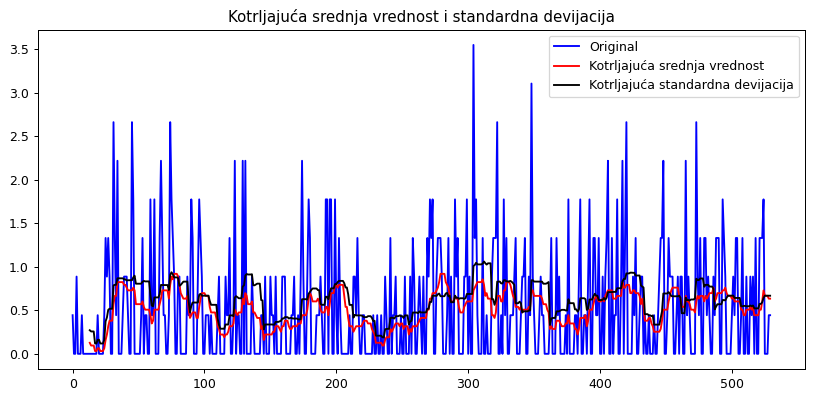

Rezultati Dickey-Fuller Testa
Test Statistics                 -5.324138
p-value                          0.000005
No. of lags used                15.000000
Number of observations used    514.000000
critical value (1%)             -3.443136
critical value (5%)             -2.867179
critical value (10%)            -2.569774
dtype: float64


In [13]:
test_stationarity(top_garage_filled['demand_value'])

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


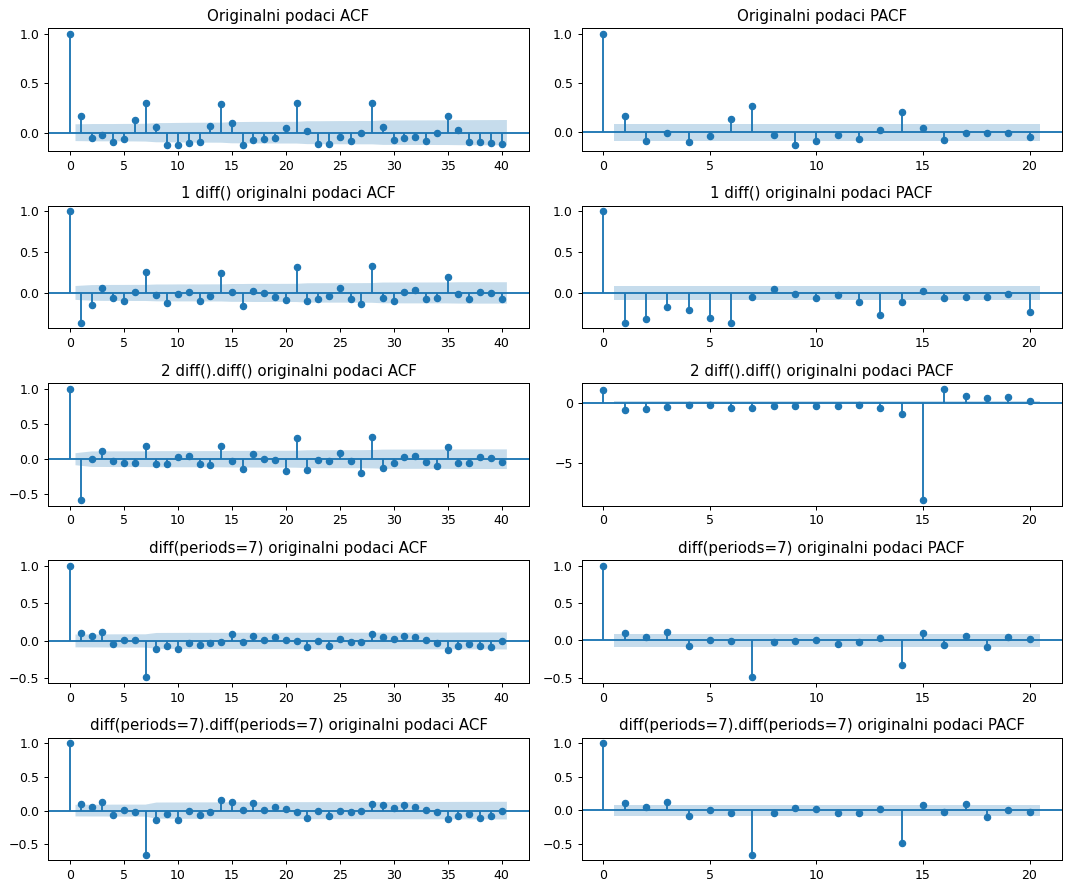

In [14]:
plot_acf_pacf(top_garage_filled, diff_period=7)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81238D-01    |proj g|=  5.18032D-01

At iterate    5    f=  8.91585D-01    |proj g|=  1.41594D-02

At iterate   10    f=  8.84295D-01    |proj g|=  1.79422D-02

At iterate   15    f=  8.72583D-01    |proj g|=  1.76862D-02

At iterate   20    f=  8.70688D-01    |proj g|=  4.34419D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   9.599D-06   8.707D-01
  F =  0.87066712677943081     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                     
Dep. Variable:                      demand_value   No. Observations:                  530
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -461.454
Date:                           Sat, 17 Jul 2021   AIC                            930.907
Time:                                   14:56:07   BIC         

/Users/mandja96/Desktop/matf-master/master-venv/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


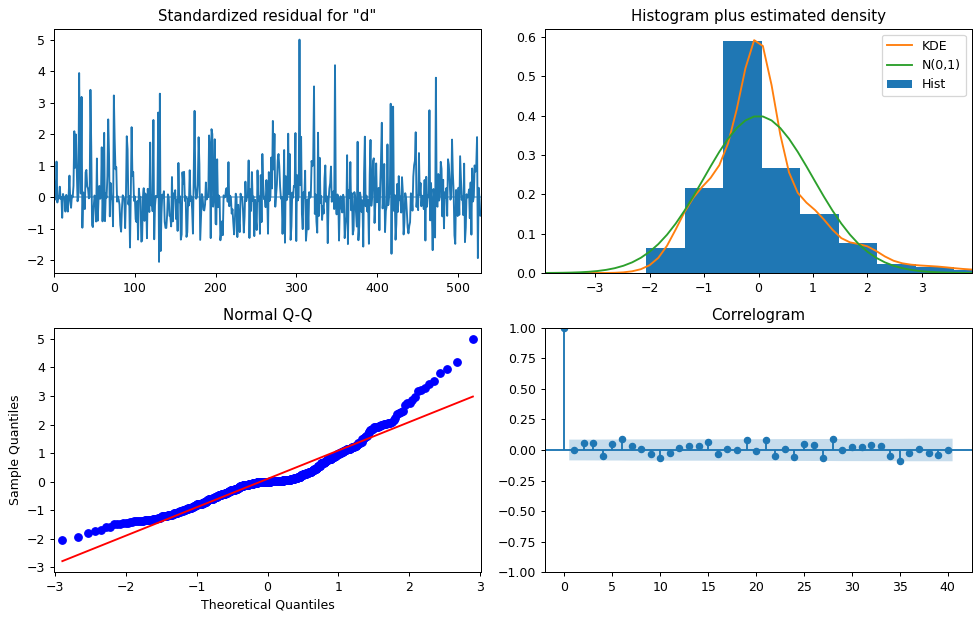

In [15]:
best_model = SARIMAX(top_garage_filled["demand_value"], 
                     order=(0, 0, 1),
                     seasonal_order=(1, 0, 1, 7)
                    ).fit()

print(best_model.summary())
plt.rcParams.update({'figure.figsize':(11, 7), 'figure.dpi':90})

# Standardized residuals over time
# Histogram plus estimated density of standardized residuals, along with a N(0,1) density plotted for reference
# Normal Q-Q plot, with Normal reference line.
# Correlogram
best_model.plot_diagnostics(lags=40)
plt.tight_layout()

In [16]:
def run_arima(arima_train_pd, 
              arima_test_pd, 
              model_info, 
              look_ahead=1):
    
    arima_train = arima_train_pd['demand_value'].values
    arima_test = arima_test_pd['demand_value'].values

    history = arima_train.copy()
    predictions = []

    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    for instance in range(len(arima_test_pd)):
        model = eval(model_info)
        model_fit = model.fit()

        start_date = arima_test_pd.iloc[instance]['date']
        
        future_to_predict = [start_date]
        step = 1
        count = 1
        while count < look_ahead:
            current_date = start_date + datetime.timedelta(days=step)
            if current_date.day_name() in days:
                count += 1
                future_to_predict.append(current_date)
            step += 1
            
        output = model_fit.forecast(look_ahead)

        # forecast [0]
        # stderr   [1]
        # conf_int [2]
        if 'SARIMAX' in model_info:
            yhat = output
        else:
            yhat = output

        date_prediction = list(zip(future_to_predict, yhat))

        predictions.append(date_prediction)

        history = np.append(history, arima_test_pd.iloc[instance]['demand_value'])

    return predictions, arima_train_pd, arima_test_pd, model_fit

def run_model(model_info, 
              data_sorted_by_date, 
              date_col="year_week", 
              date_to_start="202109", 
              look_ahead=1):
    
    train_pd = data_sorted_by_date[data_sorted_by_date[date_col] < date_to_start]
    test_pd =  data_sorted_by_date[data_sorted_by_date[date_col] >= date_to_start]

    if ('ARIMA' in model_info) or ("SARIMAX" in model_info):
        print("Arima/Sarima")
        arima_predictions, arima_train_pd, arima_test_pd, arima_model = run_arima(train_pd, 
                                                                                  test_pd, 
                                                                                  model_info, 
                                                                                  look_ahead)
        return arima_predictions, arima_model

#     elif 'Prophet' in model_info:
#         print("Prophet")
#         prophet_predictions, prophet_forecasts_df, prophet_train_pd, prophet_test_pd, prophet_model = run_prophet(train_pd, test_pd, model_info, look_ahead)
#         return prophet_predictions, prophet_model

    else:
        print(f"That model ({model_info}) is not supported.")

In [22]:
models = {
  "arima_0_0_1": "ARIMA(history, order=(0, 0, 1))",
  "sarima_0_0_1_1_0_1_7": "SARIMAX(history, order=(0, 0, 1), seasonal_order=(1, 0, 1, 7), enforce_stationary=True)",
  "sarima_1_0_1_1_0_1_7": "SARIMAX(history, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), enforce_stationary=True)",
}

results = {}

date_to_start = "2021-03-01"
look_ahead = 28 #dana

for model_name, model_info in models.items():
    print(model_info)  
    run_returned = run_model(model_info=model_info, 
                             data_sorted_by_date=top_garage_filled, 
                             date_col="date", 
                             date_to_start=date_to_start, 
                             look_ahead=look_ahead)
    
    results[model_name] = run_returned
    print()

ARIMA(history, order=(0, 0, 1))
Arima/Sarima

SARIMAX(history, order=(0, 0, 1), seasonal_order=(1, 0, 1, 7), enforce_stationary=True)
Arima/Sarima
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84176D-01    |proj g|=  5.00893D-01

At iterate    5    f=  9.04936D-01    |proj g|=  1.37465D-02

At iterate   10    f=  9.01986D-01    |proj g|=  1.57468D-02

At iterate   15    f=  8.92052D-01    |proj g|=  1.45770D-02

At iterate   20    f=  8.87181D-01    |proj g|=  1.83038D-03


 This problem is unconstrained.



At iterate   25    f=  8.87004D-01    |proj g|=  2.78931D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   6.685D-06   8.870D-01
  F =  0.88700424170810477     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83151D-01    |proj g|=  5.01971D-01

At iterate    5    f=  9.03757D-01    |proj g|=  1.36870D-02

At iterate   10    f=  9.00737D-01    |proj g|=  1.58050D-02


 This problem is unconstrained.



At iterate   15    f=  8.90909D-01    |proj g|=  1.44225D-02

At iterate   20    f=  8.86086D-01    |proj g|=  4.08017D-03

At iterate   25    f=  8.86019D-01    |proj g|=  1.99514D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   3.976D-06   8.860D-01
  F =  0.88601901405818717     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82585D-01    |proj g|=  5.00442D-01


 This problem is unconstrained.



At iterate    5    f=  9.04257D-01    |proj g|=  1.20865D-02

At iterate   10    f=  9.01136D-01    |proj g|=  2.05220D-02

At iterate   15    f=  8.89486D-01    |proj g|=  1.44322D-02

At iterate   20    f=  8.85890D-01    |proj g|=  2.61310D-03

At iterate   25    f=  8.85800D-01    |proj g|=  1.22724D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   1.372D-05   8.858D-01
  F =  0.88580011056834951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.88314D-01    |proj g|=  1.13756D-02

At iterate   20    f=  8.86042D-01    |proj g|=  6.81128D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   3.074D-07   8.860D-01
  F =  0.88603295892612788     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81023D-01    |proj g|=  4.98750D-01


 This problem is unconstrained.



At iterate    5    f=  9.04335D-01    |proj g|=  9.83463D-03

At iterate   10    f=  9.00288D-01    |proj g|=  6.52588D-02

At iterate   15    f=  8.89428D-01    |proj g|=  1.18915D-02

At iterate   20    f=  8.85764D-01    |proj g|=  6.55517D-03

At iterate   25    f=  8.85702D-01    |proj g|=  3.07047D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   3.163D-06   8.857D-01
  F =  0.88570185215631814     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.


At iterate   15    f=  8.89074D-01    |proj g|=  2.07011D-02

At iterate   20    f=  8.85483D-01    |proj g|=  9.74831D-04

At iterate   25    f=  8.85466D-01    |proj g|=  2.84290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   2.843D-05   8.855D-01
  F =  0.88546606949015449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79572D-01    |proj g|=  4.98109D-01


 This problem is unconstrained.



At iterate    5    f=  9.03665D-01    |proj g|=  1.02630D-02

At iterate   10    f=  8.98139D-01    |proj g|=  7.91174D-02

At iterate   15    f=  8.86533D-01    |proj g|=  1.18914D-02

At iterate   20    f=  8.84351D-01    |proj g|=  7.56782D-03

At iterate   25    f=  8.84331D-01    |proj g|=  1.74659D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   3.501D-06   8.843D-01
  F =  0.88433093589399925     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f=  8.96247D-01    |proj g|=  5.55454D-02

At iterate   15    f=  8.84760D-01    |proj g|=  1.59770D-02

At iterate   20    f=  8.83207D-01    |proj g|=  6.56279D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   2.836D-05   8.832D-01
  F =  0.88317152772646657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77451D-01    |proj g|=  4.99671D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.94685D-01    |proj g|=  6.22176D-02

At iterate   15    f=  8.83286D-01    |proj g|=  1.87613D-02

At iterate   20    f=  8.82176D-01    |proj g|=  7.10802D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   1.211D-06   8.822D-01
  F =  0.88217327729928829     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77156D-01    |proj g|=  5.00374D-01


 This problem is unconstrained.



At iterate    5    f=  9.00761D-01    |proj g|=  1.01629D-02

At iterate   10    f=  8.94240D-01    |proj g|=  5.98781D-02

At iterate   15    f=  8.82723D-01    |proj g|=  2.17579D-02

At iterate   20    f=  8.81577D-01    |proj g|=  7.33170D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   1.492D-06   8.816D-01
  F =  0.88155969647843457     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  9.01749D-01    |proj g|=  1.00927D-02

At iterate   10    f=  8.95825D-01    |proj g|=  5.75671D-02

At iterate   15    f=  8.84314D-01    |proj g|=  6.07099D-02

At iterate   20    f=  8.81596D-01    |proj g|=  4.48170D-03

At iterate   25    f=  8.81553D-01    |proj g|=  3.43042D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   3.430D-05   8.816D-01
  F =  0.88155317092758123     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.85818D-01    |proj g|=  1.91385D-02

At iterate   20    f=  8.81945D-01    |proj g|=  4.36512D-03

At iterate   25    f=  8.81885D-01    |proj g|=  4.64670D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   2.944D-06   8.819D-01
  F =  0.88188546700003501     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84628D-01    |proj g|=  5.01133D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  8.89113D-01    |proj g|=  4.83268D-02

At iterate   20    f=  8.84846D-01    |proj g|=  3.11375D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   5.475D-06   8.848D-01
  F =  0.88477805215608518     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83291D-01    |proj g|=  5.01192D-01

At iterate    5    f=  9.05971D-01    |proj g|=  1.15239D-02


 This problem is unconstrained.



At iterate   10    f=  9.01522D-01    |proj g|=  7.36246D-02

At iterate   15    f=  8.86615D-01    |proj g|=  9.49034D-03

At iterate   20    f=  8.83816D-01    |proj g|=  3.10639D-04

At iterate   25    f=  8.83764D-01    |proj g|=  2.42532D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   2.425D-05   8.838D-01
  F =  0.88376370162793527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  9.04616D-01    |proj g|=  1.12378D-02

At iterate   10    f=  9.00003D-01    |proj g|=  7.08254D-02

At iterate   15    f=  8.87064D-01    |proj g|=  1.29611D-02

At iterate   20    f=  8.82655D-01    |proj g|=  2.01067D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   3.284D-06   8.826D-01
  F =  0.88262589401540048     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82685D-01    |proj g|=  5.02950D-01

At iterate    5    f=  9.04506D-01    |proj g|=  1.20454D-02

At iterate   10    f=  9.00083D-01    |proj g|=  5.64445D-02

At iterate   15    f=  8.87228D-01    |proj g|=  1.66712D-02


 This problem is unconstrained.



At iterate   20    f=  8.82788D-01    |proj g|=  8.39994D-03

At iterate   25    f=  8.82722D-01    |proj g|=  2.94300D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   4.334D-05   8.827D-01
  F =  0.88272176495585175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82147D-01    |proj g|=  5.03252D-01

At iterate    5    f=  9.03360D-01    |proj g|=  1.26467D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  8.84923D-01    |proj g|=  1.43112D-02

At iterate   20    f=  8.81594D-01    |proj g|=  2.52193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   1.090D-05   8.816D-01
  F =  0.88158834816750686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81969D-01    |proj g|=  5.04296D-01

At iterate    5    f=  9.02571D-01    |proj g|=  1.32098D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  8.80734D-01    |proj g|=  2.12653D-03

At iterate   25    f=  8.80693D-01    |proj g|=  3.69171D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   3.692D-05   8.807D-01
  F =  0.88069283820319411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81586D-01    |proj g|=  5.05442D-01

At iterate    5    f=  9.01823D-01    |proj g|=  1.28480D-02

At iter

 This problem is unconstrained.


At iterate   15    f=  8.83175D-01    |proj g|=  1.22958D-02

At iterate   20    f=  8.79805D-01    |proj g|=  1.99864D-03

At iterate   25    f=  8.79778D-01    |proj g|=  3.79506D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   4.091D-05   8.798D-01
  F =  0.87977837531302328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80757D-01    |proj g|=  5.04534D-01

At itera

 This problem is unconstrained.



At iterate   15    f=  8.83573D-01    |proj g|=  1.35888D-02

At iterate   20    f=  8.78718D-01    |proj g|=  7.48512D-03

At iterate   25    f=  8.78658D-01    |proj g|=  1.99855D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   1.999D-05   8.787D-01
  F =  0.87865787169357601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79673D-01    |proj g|=  5.05027D-01


 This problem is unconstrained.



At iterate    5    f=  9.00269D-01    |proj g|=  1.20225D-02

At iterate   10    f=  8.95419D-01    |proj g|=  6.40476D-02

At iterate   15    f=  8.82501D-01    |proj g|=  1.37976D-02

At iterate   20    f=  8.77600D-01    |proj g|=  1.93752D-02

At iterate   25    f=  8.77533D-01    |proj g|=  4.51256D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   3.152D-05   8.775D-01
  F =  0.87753338751274956     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   9.891D-06   8.765D-01
  F =  0.87652340898934555     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78301D-01    |proj g|=  5.07066D-01

At iterate    5    f=  8.98211D-01    |proj g|=  1.20442D-02

At iterate   10    f=  8.93320D-01    |proj g|=  6.32838D-02

At iterate   15    f=  8.80586D-01    |proj g|=  1.36972D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  8.75729D-01    |proj g|=  5.13836D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   3.198D-05   8.757D-01
  F =  0.87572909528061860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78160D-01    |proj g|=  5.04723D-01

At iterate    5    f=  8.98980D-01    |proj g|=  1.18765D-02

At iterate   10    f=  8.93345D-01    |proj g|=  8.09923D-02

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   1.925D-06   8.767D-01
  F =  0.87667283211144265     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78097D-01    |proj g|=  5.07198D-01

At iterate    5    f=  8.98464D-01    |proj g|=  1.18840D-02

At iterate   10    f=  8.93355D-01    |proj g|=  7.82451D-02

At iterate   15    f=  8.79560D-01    |proj g|=  1.52418D-02

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   9.620D-06   8.761D-01
  F =  0.87606162881821747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77688D-01    |proj g|=  5.07666D-01

At iterate    5    f=  8.97348D-01    |proj g|=  1.16441D-02

At iterate   10    f=  8.92512D-01    |proj g|=  7.11525D-02

At iterate   15    f=  8.79823D-01    |proj g|=  1.31211D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  8.75163D-01    |proj g|=  8.25489D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   5.275D-05   8.752D-01
  F =  0.87516332770650485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76620D-01    |proj g|=  5.07691D-01

At iterate    5    f=  8.96289D-01    |proj g|=  1.16161D-02

At iterate   10    f=  8.91063D-01    |proj g|=  7.47190D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  8.74060D-01    |proj g|=  1.78365D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   1.341D-05   8.741D-01
  F =  0.87405999787519284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75501D-01    |proj g|=  5.08362D-01

At iterate    5    f=  8.95189D-01    |proj g|=  1.16240D-02

At iterate   10    f=  8.89328D-01    |proj g|=  7.95515D-02

At iter

 This problem is unconstrained.


At iterate   20    f=  8.72975D-01    |proj g|=  1.15849D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   7.293D-06   8.730D-01
  F =  0.87295295561684438     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83809D-01    |proj g|=  5.04015D-01

At iterate    5    f=  9.03110D-01    |proj g|=  1.35716D-02

At iterate   10    f=  8.86746D-01    |proj g|=  1.44648D-02


 This problem is unconstrained.



At iterate   15    f=  8.80849D-01    |proj g|=  1.82054D-02

At iterate   20    f=  8.80248D-01    |proj g|=  1.60863D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   4.696D-06   8.802D-01
  F =  0.88024821495185068     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83836D-01    |proj g|=  5.01797D-01

At iterate    5    f=  9.02730D-01    |proj g|=  1.53216D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  8.80109D-01    |proj g|=  2.41931D-03

At iterate   20    f=  8.79811D-01    |proj g|=  2.75817D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   3.176D-05   8.798D-01
  F =  0.87981120505383548     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84208D-01    |proj g|=  5.03394D-01

At iterate    5    f=  9.02866D-01    |proj g|=  1.12757D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  8.81022D-01    |proj g|=  5.34038D-02

At iterate   20    f=  8.78962D-01    |proj g|=  1.66317D-03

At iterate   25    f=  8.78960D-01    |proj g|=  1.25222D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   2.640D-06   8.790D-01
  F =  0.87895991620231595     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83549D-01    |proj g|=  5.03394D-01


 This problem is unconstrained.



At iterate    5    f=  9.01552D-01    |proj g|=  1.11086D-02

At iterate   10    f=  8.90564D-01    |proj g|=  2.11456D-02

At iterate   15    f=  8.79385D-01    |proj g|=  1.56845D-02

At iterate   20    f=  8.78075D-01    |proj g|=  2.09709D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   1.112D-06   8.781D-01
  F =  0.87807198014095067     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   1.301D-05   8.802D-01
  F =  0.88015125601230992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82570D-01    |proj g|=  5.00564D-01

At iterate    5    f=  9.02957D-01    |proj g|=  1.30321D-02

At iterate   10    f=  8.98637D-01    |proj g|=  4.89266D-02

At iterate   15    f=  8.84507D-01    |proj g|=  2.33289D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  8.79145D-01    |proj g|=  1.80798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     34      1     0     0   5.123D-07   8.791D-01
  F =  0.87914388275365973     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81526D-01    |proj g|=  5.01020D-01

At iterate    5    f=  9.01876D-01    |proj g|=  1.29790D-02

At iterate   10    f=  8.97559D-01    |proj g|=  4.90243D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  8.78117D-01    |proj g|=  2.10470D-03

At iterate   25    f=  8.78054D-01    |proj g|=  3.72370D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   3.137D-05   8.781D-01
  F =  0.87805392866650156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80732D-01    |proj g|=  5.00380D-01

At iterate    5    f=  9.02387D-01    |proj g|=  1.12428D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  8.78822D-01    |proj g|=  1.18177D-03

At iterate   25    f=  8.78658D-01    |proj g|=  8.32386D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   8.324D-06   8.787D-01
  F =  0.87865792430778134     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.92886D-01    |proj g|=  4.93890D-01

At iterate    5    f=  9.12690D-01    |proj g|=  1.16312D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  8.95385D-01    |proj g|=  1.85151D-02

At iterate   20    f=  8.92485D-01    |proj g|=  9.70711D-04

At iterate   25    f=  8.92471D-01    |proj g|=  8.36045D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   8.125D-06   8.925D-01
  F =  0.89247099615980541     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.92187D-01    |proj g|=  4.93271D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  9.03968D-01    |proj g|=  2.21515D-02

At iterate   15    f=  8.93160D-01    |proj g|=  1.32419D-02

At iterate   20    f=  8.91462D-01    |proj g|=  1.54827D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   9.845D-06   8.915D-01
  F =  0.89145883361631129     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91412D-01    |proj g|=  4.92994D-01


 This problem is unconstrained.



At iterate    5    f=  9.11055D-01    |proj g|=  1.15997D-02

At iterate   10    f=  9.03923D-01    |proj g|=  2.59160D-02

At iterate   15    f=  8.93009D-01    |proj g|=  2.71457D-02

At iterate   20    f=  8.90473D-01    |proj g|=  1.31789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   5.817D-06   8.905D-01
  F =  0.89046573542595986     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  9.11165D-01    |proj g|=  1.17168D-02

At iterate   10    f=  9.02426D-01    |proj g|=  1.99861D-02

At iterate   15    f=  8.92059D-01    |proj g|=  3.08556D-02

At iterate   20    f=  8.89899D-01    |proj g|=  1.74219D-03

At iterate   25    f=  8.89878D-01    |proj g|=  2.99295D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   2.993D-06   8.899D-01
  F =  0.88987812019753443     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   25    f=  8.88812D-01    |proj g|=  3.29717D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   3.297D-06   8.888D-01
  F =  0.88881189186475096     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89788D-01    |proj g|=  4.98625D-01

At iterate    5    f=  9.08994D-01    |proj g|=  1.13415D-02

At iterate   10    f=  9.00417D-01    |proj g|=  1.86202D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  8.87738D-01    |proj g|=  3.67973D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   2.078D-05   8.877D-01
  F =  0.88773624451275568     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90345D-01    |proj g|=  5.02185D-01

At iterate    5    f=  9.08879D-01    |proj g|=  1.17993D-02

At iterate   10    f=  9.00413D-01    |proj g|=  1.76369D-02


 This problem is unconstrained.



At iterate   15    f=  8.91476D-01    |proj g|=  1.87390D-02

At iterate   20    f=  8.88018D-01    |proj g|=  9.57477D-03

At iterate   25    f=  8.87964D-01    |proj g|=  4.07586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     34      1     0     0   1.177D-04   8.880D-01
  F =  0.88796427154215896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90791D-01    |proj g|=  5.02097D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  8.89161D-01    |proj g|=  1.61804D-02

At iterate   20    f=  8.87637D-01    |proj g|=  1.13177D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   2.577D-05   8.876D-01
  F =  0.88763187800841836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89835D-01    |proj g|=  5.02074D-01

At iterate    5    f=  9.06845D-01    |proj g|=  1.28916D-02



 This problem is unconstrained.


At iterate   10    f=  8.98389D-01    |proj g|=  1.88058D-02

At iterate   15    f=  8.88377D-01    |proj g|=  6.37163D-03

At iterate   20    f=  8.86929D-01    |proj g|=  8.18555D-04

At iterate   25    f=  8.86927D-01    |proj g|=  1.24855D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   1.249D-05   8.869D-01
  F =  0.88692738908391688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate   10    f=  8.97498D-01    |proj g|=  1.74673D-02

At iterate   15    f=  8.87618D-01    |proj g|=  7.87752D-03

At iterate   20    f=  8.86177D-01    |proj g|=  4.07377D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   3.778D-06   8.862D-01
  F =  0.88617370561535946     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89002D-01    |proj g|=  5.03797D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.98382D-01    |proj g|=  2.00025D-02

At iterate   15    f=  8.89040D-01    |proj g|=  1.38954D-02

At iterate   20    f=  8.86201D-01    |proj g|=  2.74273D-03

At iterate   25    f=  8.86182D-01    |proj g|=  2.00148D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     33      1     0     0   8.375D-06   8.862D-01
  F =  0.88618157337666059     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  9.05125D-01    |proj g|=  1.14948D-02

At iterate   10    f=  8.97554D-01    |proj g|=  2.03535D-02

At iterate   15    f=  8.87558D-01    |proj g|=  9.99443D-03

At iterate   20    f=  8.85153D-01    |proj g|=  8.60149D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   2.130D-06   8.851D-01
  F =  0.88514443639445628     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  9.04082D-01    |proj g|=  1.12937D-02

At iterate   10    f=  8.96124D-01    |proj g|=  1.74117D-02

At iterate   15    f=  8.85918D-01    |proj g|=  2.73318D-02

At iterate   20    f=  8.84087D-01    |proj g|=  1.18590D-03

At iterate   25    f=  8.84085D-01    |proj g|=  3.53648D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   2.009D-06   8.841D-01
  F =  0.88408459760817393     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86608D-01    |proj g|=  5.05599D-01

At iterate    5    f=  9.03782D-01    |proj g|=  9.93231D-03

At iterate   10    f=  8.96265D-01    |proj g|=  3.32547D-02

At iterate   15    f=  8.85257D-01    |proj g|=  4.18169D-02

At iterate   20    f=  8.83150D-01    |proj g|=  1.15870D-02

At iterate   25    f=  8.83112D-01    |proj g|=  2.69636D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     32      1     0     0   

 This problem is unconstrained.



At iterate   20    f=  8.82468D-01    |proj g|=  4.28369D-03

At iterate   25    f=  8.82445D-01    |proj g|=  4.71291D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   1.053D-05   8.824D-01
  F =  0.88244496940053319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88296D-01    |proj g|=  5.03770D-01

At iterate    5    f=  9.04991D-01    |proj g|=  1.09283D-02



 This problem is unconstrained.


At iterate   10    f=  8.97232D-01    |proj g|=  2.82074D-02

At iterate   15    f=  8.85913D-01    |proj g|=  1.06640D-02

At iterate   20    f=  8.82879D-01    |proj g|=  1.18175D-03

At iterate   25    f=  8.82862D-01    |proj g|=  3.54341D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   3.587D-06   8.829D-01
  F =  0.88286220187355668     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  9.05048D-01    |proj g|=  1.16447D-02

At iterate   10    f=  8.96490D-01    |proj g|=  2.21088D-02

At iterate   15    f=  8.86116D-01    |proj g|=  2.73069D-02

At iterate   20    f=  8.82884D-01    |proj g|=  2.74319D-03

At iterate   25    f=  8.82863D-01    |proj g|=  3.53158D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   3.532D-06   8.829D-01
  F =  0.88286264996133801     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   25    f=  8.82087D-01    |proj g|=  2.57011D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   2.570D-05   8.821D-01
  F =  0.88208713790344651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88296D-01    |proj g|=  5.05409D-01

At iterate    5    f=  9.03243D-01    |proj g|=  1.31042D-02

At iterate   10    f=  8.93736D-01    |proj g|=  1.75374D-02



 This problem is unconstrained.


At iterate   15    f=  8.82990D-01    |proj g|=  2.07048D-02

At iterate   20    f=  8.81050D-01    |proj g|=  9.39586D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   8.102D-06   8.810D-01
  F =  0.88104581094148371     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87204D-01    |proj g|=  5.06226D-01

At iterate    5    f=  9.02124D-01    |proj g|=  1.29964D-02


 This problem is unconstrained.



At iterate   10    f=  8.93045D-01    |proj g|=  1.92987D-02

At iterate   15    f=  8.82133D-01    |proj g|=  2.44629D-02

At iterate   20    f=  8.80003D-01    |proj g|=  2.02795D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   4.349D-06   8.800D-01
  F =  0.88000018487191889     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90056D-01    |proj g|=  5.08507D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.94191D-01    |proj g|=  1.96994D-02

At iterate   15    f=  8.83994D-01    |proj g|=  9.46497D-03

At iterate   20    f=  8.82286D-01    |proj g|=  1.73032D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   8.435D-06   8.823D-01
  F =  0.88227640743991687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89828D-01    |proj g|=  5.09144D-01


 This problem is unconstrained.



At iterate    5    f=  9.03226D-01    |proj g|=  1.39571D-02

At iterate   10    f=  8.93798D-01    |proj g|=  1.65232D-02

At iterate   15    f=  8.83438D-01    |proj g|=  1.12320D-02

At iterate   20    f=  8.81769D-01    |proj g|=  6.54757D-04

At iterate   25    f=  8.81766D-01    |proj g|=  4.39559D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   4.396D-06   8.818D-01
  F =  0.88176620134546912     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   25    f=  8.80751D-01    |proj g|=  9.71199D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   9.712D-06   8.808D-01
  F =  0.88075093758517853     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89042D-01    |proj g|=  5.08380D-01

At iterate    5    f=  9.01646D-01    |proj g|=  1.56696D-02

At iterate   10    f=  8.93120D-01    |proj g|=  1.59532D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  8.81214D-01    |proj g|=  2.78999D-03

At iterate   25    f=  8.81190D-01    |proj g|=  6.60011D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   6.132D-06   8.812D-01
  F =  0.88118979985264634     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88148D-01    |proj g|=  5.07915D-01

At iterate    5    f=  9.02578D-01    |proj g|=  1.30190D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  8.84156D-01    |proj g|=  7.99948D-03

At iterate   20    f=  8.82363D-01    |proj g|=  1.60331D-03

At iterate   25    f=  8.82358D-01    |proj g|=  4.08647D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   8.881D-07   8.824D-01
  F =  0.88235794577168236     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87264D-01    |proj g|=  5.07979D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.93864D-01    |proj g|=  2.15293D-02

At iterate   15    f=  8.83393D-01    |proj g|=  9.08936D-03

At iterate   20    f=  8.81395D-01    |proj g|=  5.05364D-03

At iterate   25    f=  8.81381D-01    |proj g|=  4.53370D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   2.885D-06   8.814D-01
  F =  0.88138136737485273     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86307D-01    |proj g|=  5.08286D-01

At iterate    5    f=  9.00885D-01    |proj g|=  1.22268D-02

At iterate   10    f=  8.93311D-01    |proj g|=  2.45545D-02

At iterate   15    f=  8.82381D-01    |proj g|=  1.45795D-02

At iterate   20    f=  8.80358D-01    |proj g|=  2.95157D-03

At iterate   25    f=  8.80352D-01    |proj g|=  2.31127D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   2.311D-05   8.804D-01
  F =  0.88035185237146

 This problem is unconstrained.



At iterate   20    f=  8.79686D-01    |proj g|=  1.98382D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   2.085D-05   8.797D-01
  F =  0.87968369090461918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85146D-01    |proj g|=  5.08827D-01

At iterate    5    f=  9.00338D-01    |proj g|=  9.85547D-03

At iterate   10    f=  8.93064D-01    |proj g|=  3.85327D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  8.78753D-01    |proj g|=  1.43139D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   9.866D-06   8.787D-01
  F =  0.87873873757556009     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84497D-01    |proj g|=  5.08175D-01

At iterate    5    f=  9.00090D-01    |proj g|=  1.03962D-02

At iterate   10    f=  8.92362D-01    |proj g|=  5.09745D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  8.78046D-01    |proj g|=  4.27875D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   6.389D-05   8.780D-01
  F =  0.87802846507448162     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85465D-01    |proj g|=  5.10663D-01

At iterate    5    f=  9.00127D-01    |proj g|=  9.70256D-03

At iterate   10    f=  8.93009D-01    |proj g|=  3.61661D-02


 This problem is unconstrained.



At iterate   15    f=  8.81146D-01    |proj g|=  1.50556D-02

At iterate   20    f=  8.78685D-01    |proj g|=  3.33925D-03

At iterate   25    f=  8.78676D-01    |proj g|=  3.34804D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   3.348D-05   8.787D-01
  F =  0.87867556105332378     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85559D-01    |proj g|=  5.12055D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.92292D-01    |proj g|=  3.31148D-02

At iterate   15    f=  8.80779D-01    |proj g|=  2.14955D-02

At iterate   20    f=  8.77957D-01    |proj g|=  1.62879D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   6.645D-06   8.779D-01
  F =  0.87794640704651383     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84551D-01    |proj g|=  5.11698D-01


 This problem is unconstrained.



At iterate    5    f=  8.98670D-01    |proj g|=  1.00234D-02

At iterate   10    f=  8.91455D-01    |proj g|=  3.54592D-02

At iterate   15    f=  8.79645D-01    |proj g|=  1.37072D-02

At iterate   20    f=  8.76946D-01    |proj g|=  1.10280D-03

At iterate   25    f=  8.76935D-01    |proj g|=  1.02039D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   1.784D-07   8.769D-01
  F =  0.87693525372331793     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   25    f=  8.75919D-01    |proj g|=  2.18207D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   1.695D-06   8.759D-01
  F =  0.87591892433777552     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82777D-01    |proj g|=  5.13317D-01

At iterate    5    f=  8.96604D-01    |proj g|=  1.06058D-02

At iterate   10    f=  8.89291D-01    |proj g|=  2.54524D-02

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   3.791D-05   8.752D-01
  F =  0.87522921429085643     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83542D-01    |proj g|=  5.14194D-01

At iterate    5    f=  8.96187D-01    |proj g|=  1.12508D-02

At iterate   10    f=  8.89053D-01    |proj g|=  2.54918D-02

At iterate   15    f=  8.77853D-01    |proj g|=  3.27063D-02



 This problem is unconstrained.


At iterate   20    f=  8.75306D-01    |proj g|=  1.15655D-03

At iterate   25    f=  8.75291D-01    |proj g|=  1.10944D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   1.109D-05   8.753D-01
  F =  0.87529127613788560     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83495D-01    |proj g|=  5.12458D-01

At iterate    5    f=  8.96269D-01    |proj g|=  1.18393D-02

At itera

 This problem is unconstrained.



At iterate   15    f=  8.79384D-01    |proj g|=  1.06830D-02

At iterate   20    f=  8.76296D-01    |proj g|=  2.82766D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   3.147D-05   8.763D-01
  F =  0.87626906169201635     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82371D-01    |proj g|=  5.13072D-01

At iterate    5    f=  8.96103D-01    |proj g|=  1.08979D-02

At iterate   10    f=  8.88929D-01    |proj g|=  2.63087D-02

At iterate   15    f=  8.77551D-01    |proj g|=  7.18574D-03

At iterate   20    f=  8.76172D-01    |proj g|=  9.02558D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   8.008D-06   8.762D-01
  F =  0.87616822645687220     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.95361D-01    |proj g|=  1.08485D-02

At iterate   10    f=  8.88117D-01    |proj g|=  2.39749D-02

At iterate   15    f=  8.77529D-01    |proj g|=  1.35682D-02

At iterate   20    f=  8.75177D-01    |proj g|=  1.43079D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   2.993D-05   8.752D-01
  F =  0.87516923030194582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  8.75861D-01    |proj g|=  1.23141D-02

At iterate   20    f=  8.74194D-01    |proj g|=  7.19287D-03

At iterate   25    f=  8.74166D-01    |proj g|=  1.34537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   2.800D-06   8.742D-01
  F =  0.87416568056354371     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80084D-01    |proj g|=  5.15865D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  8.73180D-01    |proj g|=  7.66123D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   1.469D-06   8.732D-01
  F =  0.87316394428605471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79621D-01    |proj g|=  5.17856D-01

At iterate    5    f=  8.92816D-01    |proj g|=  1.01892D-02

At iterate   10    f=  8.84133D-01    |proj g|=  1.94210D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  8.72241D-01    |proj g|=  8.44016D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   3.074D-06   8.722D-01
  F =  0.87222048476897740     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79151D-01    |proj g|=  5.16841D-01


 This problem is unconstrained.



At iterate    5    f=  8.92856D-01    |proj g|=  9.48881D-03

At iterate   10    f=  8.83498D-01    |proj g|=  2.11595D-02

At iterate   15    f=  8.73709D-01    |proj g|=  5.74644D-03

At iterate   20    f=  8.71708D-01    |proj g|=  7.11886D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   3.332D-06   8.717D-01
  F =  0.87168948997636131     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.92313D-01    |proj g|=  9.76360D-03

At iterate   10    f=  8.83731D-01    |proj g|=  2.61936D-02

At iterate   15    f=  8.72855D-01    |proj g|=  5.38419D-03

At iterate   20    f=  8.70934D-01    |proj g|=  6.60048D-04

At iterate   25    f=  8.70915D-01    |proj g|=  1.38218D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   1.071D-07   8.709D-01
  F =  0.87091456143928714     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.


At iterate    5    f=  8.91803D-01    |proj g|=  1.06759D-02

At iterate   10    f=  8.82910D-01    |proj g|=  1.66374D-02

At iterate   15    f=  8.72956D-01    |proj g|=  7.74895D-03

At iterate   20    f=  8.71303D-01    |proj g|=  6.91823D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   6.409D-06   8.713D-01
  F =  0.87129611296699117     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  8.92099D-01    |proj g|=  1.18883D-02

At iterate   10    f=  8.84653D-01    |proj g|=  2.89615D-02

At iterate   15    f=  8.74434D-01    |proj g|=  1.01126D-02

At iterate   20    f=  8.71133D-01    |proj g|=  3.53506D-03

At iterate   25    f=  8.71092D-01    |proj g|=  4.93162D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   3.734D-06   8.711D-01
  F =  0.87109218261824850     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  8.90883D-01    |proj g|=  1.23098D-02

At iterate   10    f=  8.82766D-01    |proj g|=  2.66285D-02

At iterate   15    f=  8.73123D-01    |proj g|=  1.53475D-02

At iterate   20    f=  8.70170D-01    |proj g|=  7.87107D-04

At iterate   25    f=  8.70121D-01    |proj g|=  2.51855D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   1.540D-07   8.701D-01
  F =  0.87012050768241278     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   20    f=  8.69139D-01    |proj g|=  2.77730D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   4.000D-06   8.691D-01
  F =  0.86913258472709809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79349D-01    |proj g|=  5.22343D-01

At iterate    5    f=  8.90210D-01    |proj g|=  1.27432D-02

At iterate   10    f=  8.81561D-01    |proj g|=  2.23819D-02


 This problem is unconstrained.



At iterate   15    f=  8.70653D-01    |proj g|=  5.67586D-03

At iterate   20    f=  8.69123D-01    |proj g|=  4.78591D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   9.204D-06   8.691D-01
  F =  0.86911745929501061     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79431D-01    |proj g|=  5.23089D-01



 This problem is unconstrained.


At iterate    5    f=  8.89344D-01    |proj g|=  1.33629D-02

At iterate   10    f=  8.81268D-01    |proj g|=  2.20587D-02

At iterate   15    f=  8.71532D-01    |proj g|=  1.18769D-02

At iterate   20    f=  8.68754D-01    |proj g|=  6.74521D-03

At iterate   25    f=  8.68729D-01    |proj g|=  2.72965D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   8.663D-06   8.687D-01
  F =  0.86872888092756984     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80696D-01    |proj g|=  5.22154D-01

At iterate    5    f=  8.90282D-01    |proj g|=  1.41102D-02

At iterate   10    f=  8.81417D-01    |proj g|=  2.29195D-02

At iterate   15    f=  8.70921D-01    |proj g|=  1.32806D-02

At iterate   20    f=  8.68721D-01    |proj g|=  5.17101D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   5.113D-06   8.687D-01
  F =  0.86871839453142785     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  8.83536D-01    |proj g|=  1.62069D-02

At iterate   15    f=  8.72856D-01    |proj g|=  1.64432D-02

At iterate   20    f=  8.71212D-01    |proj g|=  3.07223D-04

At iterate   25    f=  8.71210D-01    |proj g|=  9.53004D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   9.530D-07   8.712D-01
  F =  0.87121047305078791     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.94412D-01    |proj g|=  1.55190D-02

At iterate   10    f=  8.85903D-01    |proj g|=  1.57903D-02

At iterate   15    f=  8.76420D-01    |proj g|=  1.93647D-02

At iterate   20    f=  8.73883D-01    |proj g|=  1.00098D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   2.013D-05   8.738D-01
  F =  0.87384929678727730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83786D-01    |proj g|=  5.16759D-01

At iterate    5    f=  8.93723D-01    |proj g|=  1.53928D-02

At iterate   10    f=  8.85283D-01    |proj g|=  1.62949D-02

At iterate   15    f=  8.75192D-01    |proj g|=  2.06111D-02

At iterate   20    f=  8.72968D-01    |proj g|=  1.86797D-03

At iterate   25    f=  8.72955D-01    |proj g|=  8.46839D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  8.92506D-01    |proj g|=  1.56961D-02

At iterate   10    f=  8.85069D-01    |proj g|=  1.77887D-02

At iterate   15    f=  8.73699D-01    |proj g|=  9.36236D-03

At iterate   20    f=  8.71986D-01    |proj g|=  1.33190D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   7.465D-06   8.720D-01
  F =  0.87198072739450516     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


At iterate   15    f=  8.73189D-01    |proj g|=  9.30967D-03

At iterate   20    f=  8.71347D-01    |proj g|=  2.24237D-03

At iterate   25    f=  8.71344D-01    |proj g|=  3.82848D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   3.828D-05   8.713D-01
  F =  0.87134391884710216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

SARIMAX(history, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), enforce_stationary=True)
Arima/Sarima
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 varia

 This problem is unconstrained.



At iterate   10    f=  8.91725D-01    |proj g|=  1.32856D-02

At iterate   15    f=  8.85401D-01    |proj g|=  4.18706D-02

At iterate   20    f=  8.84619D-01    |proj g|=  1.36542D-02

At iterate   25    f=  8.83249D-01    |proj g|=  1.79068D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     37      1     0     0   6.881D-06   8.832D-01
  F =  0.88324632659559377     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  8.83495D-01    |proj g|=  1.10326D-02

At iterate   25    f=  8.82247D-01    |proj g|=  1.20602D-03

At iterate   30    f=  8.82195D-01    |proj g|=  2.42976D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     38      1     0     0   2.503D-06   8.822D-01
  F =  0.88219485811329190     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54939D-01    |proj g|=  3.73704D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  8.83783D-01    |proj g|=  1.87641D-02

At iterate   20    f=  8.83092D-01    |proj g|=  1.28538D-02

At iterate   25    f=  8.81960D-01    |proj g|=  1.02087D-02

At iterate   30    f=  8.81895D-01    |proj g|=  6.64956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     36      1     0     0   6.025D-06   8.819D-01
  F =  0.88189441947258340     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  8.84351D-01    |proj g|=  2.21715D-02

At iterate   20    f=  8.83545D-01    |proj g|=  3.99999D-03

At iterate   25    f=  8.82117D-01    |proj g|=  4.13759D-03

At iterate   30    f=  8.82009D-01    |proj g|=  3.53628D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     37      1     0     0   9.668D-06   8.820D-01
  F =  0.88200863422463605     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


At iterate   15    f=  8.83330D-01    |proj g|=  2.50935D-02

At iterate   20    f=  8.82865D-01    |proj g|=  9.96873D-03

At iterate   25    f=  8.81601D-01    |proj g|=  1.62138D-02

At iterate   30    f=  8.81483D-01    |proj g|=  1.96468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     38      1     0     0   6.441D-06   8.815D-01
  F =  0.88148017330660944     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate   15    f=  8.82897D-01    |proj g|=  3.63140D-03

At iterate   20    f=  8.82507D-01    |proj g|=  1.07132D-02

At iterate   25    f=  8.81016D-01    |proj g|=  3.65555D-03

At iterate   30    f=  8.80857D-01    |proj g|=  5.30148D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     36      1     0     0   3.412D-06   8.809D-01
  F =  0.88085726857135427     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   25    f=  8.79923D-01    |proj g|=  1.94172D-02

At iterate   30    f=  8.79832D-01    |proj g|=  8.57963D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     37      1     0     0   7.838D-06   8.798D-01
  F =  0.87983223766761764     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50310D-01    |proj g|=  3.72479D-01


 This problem is unconstrained.



At iterate    5    f=  8.94589D-01    |proj g|=  7.90706D-03

At iterate   10    f=  8.87510D-01    |proj g|=  1.60170D-02

At iterate   15    f=  8.80915D-01    |proj g|=  1.10165D-02

At iterate   20    f=  8.80328D-01    |proj g|=  2.74294D-03

At iterate   25    f=  8.78813D-01    |proj g|=  5.08775D-03

At iterate   30    f=  8.78726D-01    |proj g|=  7.88406D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     38      1     0     0   2.668D-06   8.787D-01
  F =  0.87872596031437900     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  8.79877D-01    |proj g|=  1.27349D-02

At iterate   20    f=  8.79230D-01    |proj g|=  2.15677D-03

At iterate   25    f=  8.77762D-01    |proj g|=  6.29887D-03

At iterate   30    f=  8.77637D-01    |proj g|=  2.50308D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     35      1     0     0   1.524D-06   8.776D-01
  F =  0.87763749190922713     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49117D-01    |proj g|=  3.74284D-01

At iterate    5    f=  8.93071D-01    |proj g|=  7.85678D-03

At iterate   10    f=  8.86277D-01    |proj g|=  1.57784D-02

At iterate   15    f=  8.79477D-01    |proj g|=  1.27623D-02

At iterate   20    f=  8.78677D-01    |proj g|=  3.56129D-03

At iterate   25    f=  8.77233D-01    |proj g|=  5.34788D-03

At iterate   30    f=  8.77147D-01    |proj g|=  1.29726D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.94342D-01    |proj g|=  7.98660D-03

At iterate   10    f=  8.87192D-01    |proj g|=  1.54815D-02

At iterate   15    f=  8.79728D-01    |proj g|=  1.44068D-02

At iterate   20    f=  8.78935D-01    |proj g|=  2.22252D-03

At iterate   25    f=  8.77845D-01    |proj g|=  1.92607D-02

At iterate   30    f=  8.77420D-01    |proj g|=  1.25987D-03

At iterate   35    f=  8.77418D-01    |proj g|=  1.76743D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     46      1     0     0   1.767D-05   8.774D-01
  F =  0.87741762452527072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.95763D-01    |proj g|=  8.48544D-03

At iterate   10    f=  8.87979D-01    |proj g|=  1.62523D-02

At iterate   15    f=  8.79568D-01    |proj g|=  9.33348D-03

At iterate   20    f=  8.78753D-01    |proj g|=  6.62354D-03

At iterate   25    f=  8.77755D-01    |proj g|=  4.57838D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   1.257D-05   8.778D-01
  F =  0.87775313447195735     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.81643D-01    |proj g|=  4.91618D-03

At iterate   20    f=  8.80822D-01    |proj g|=  2.05747D-03

At iterate   25    f=  8.80331D-01    |proj g|=  2.15620D-03

At iterate   30    f=  8.80324D-01    |proj g|=  9.92739D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     37      1     0     0   9.927D-06   8.803D-01
  F =  0.88032359678585448     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


At iterate   20    f=  8.79841D-01    |proj g|=  5.68521D-03

At iterate   25    f=  8.79476D-01    |proj g|=  2.39305D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     34      1     0     0   2.615D-06   8.795D-01
  F =  0.87946710942724937     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52071D-01    |proj g|=  3.78590D-01



 This problem is unconstrained.


At iterate    5    f=  8.96693D-01    |proj g|=  8.94202D-03

At iterate   10    f=  8.87340D-01    |proj g|=  1.72086D-02

At iterate   15    f=  8.79493D-01    |proj g|=  6.67096D-03

At iterate   20    f=  8.78916D-01    |proj g|=  2.25601D-03

At iterate   25    f=  8.78414D-01    |proj g|=  1.47124D-03

At iterate   30    f=  8.78398D-01    |proj g|=  6.85445D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     33      1     0     0   6.854D-06   8.784D-01
  F =  0.87839844632053565     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate    5    f=  8.95410D-01    |proj g|=  9.07665D-03

At iterate   10    f=  8.86329D-01    |proj g|=  1.66478D-02

At iterate   15    f=  8.78949D-01    |proj g|=  3.59260D-02

At iterate   20    f=  8.77846D-01    |proj g|=  1.76647D-03

At iterate   25    f=  8.77586D-01    |proj g|=  1.00735D-02

At iterate   30    f=  8.77496D-01    |proj g|=  6.48268D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     38      1     0     0   3.471D-06   8.775D-01
  F =  0.87749620014598406     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  8.80243D-01    |proj g|=  1.71510D-02

At iterate   20    f=  8.78519D-01    |proj g|=  1.02399D-02

At iterate   25    f=  8.78402D-01    |proj g|=  2.25601D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   5.039D-06   8.784D-01
  F =  0.87840183199738786     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52097D-01    |proj g|=  3.79258D-01


 This problem is unconstrained.



At iterate    5    f=  8.95201D-01    |proj g|=  9.74048D-03

At iterate   10    f=  8.85828D-01    |proj g|=  1.85338D-02

At iterate   15    f=  8.79195D-01    |proj g|=  1.75114D-02

At iterate   20    f=  8.77341D-01    |proj g|=  6.40250D-03

At iterate   25    f=  8.77276D-01    |proj g|=  6.05601D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     32      1     0     0   1.174D-05   8.773D-01
  F =  0.87727564151403892     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  8.94187D-01    |proj g|=  9.92938D-03

At iterate   10    f=  8.84818D-01    |proj g|=  1.83578D-02

At iterate   15    f=  8.78382D-01    |proj g|=  2.23352D-02

At iterate   20    f=  8.76401D-01    |proj g|=  8.20389D-03

At iterate   25    f=  8.76255D-01    |proj g|=  5.40589D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   7.011D-06   8.763D-01
  F =  0.87625531566406534     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   20    f=  8.76474D-01    |proj g|=  1.24289D-02

At iterate   25    f=  8.75438D-01    |proj g|=  1.73873D-03

At iterate   30    f=  8.75394D-01    |proj g|=  9.41386D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     41      1     0     0   1.085D-05   8.754D-01
  F =  0.87539407670871983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49814D-01    |proj g|=  3.79716D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  8.75438D-01    |proj g|=  7.55223D-03

At iterate   25    f=  8.74403D-01    |proj g|=  7.56067D-03

At iterate   30    f=  8.74271D-01    |proj g|=  1.95578D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     37      1     0     0   5.104D-06   8.743D-01
  F =  0.87427061581233745     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48777D-01    |proj g|=  3.80118D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.82864D-01    |proj g|=  1.55584D-02

At iterate   15    f=  8.74959D-01    |proj g|=  3.46690D-03

At iterate   20    f=  8.74038D-01    |proj g|=  1.51426D-02

At iterate   25    f=  8.73153D-01    |proj g|=  6.06301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   9.941D-06   8.731D-01
  F =  0.87314874000318177     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.90860D-01    |proj g|=  9.21492D-03

At iterate   10    f=  8.82062D-01    |proj g|=  1.50177D-02

At iterate   15    f=  8.73913D-01    |proj g|=  1.44413D-02

At iterate   20    f=  8.73183D-01    |proj g|=  1.34225D-02

At iterate   25    f=  8.72182D-01    |proj g|=  8.84732D-03

At iterate   30    f=  8.72147D-01    |proj g|=  3.74218D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     34      1     0     0   3.742D-06   8.721D-01
  F =  0.87214680038354286     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  8.72251D-01    |proj g|=  4.24014D-03

At iterate   25    f=  8.71441D-01    |proj g|=  1.70125D-02

At iterate   30    f=  8.71355D-01    |proj g|=  2.69606D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     45      1     0     0   2.696D-05   8.714D-01
  F =  0.87135491794741782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47308D-01    |proj g|=  3.80392D-01


 This problem is unconstrained.



At iterate    5    f=  8.90516D-01    |proj g|=  9.38187D-03

At iterate   10    f=  8.81896D-01    |proj g|=  1.55584D-02

At iterate   15    f=  8.74229D-01    |proj g|=  1.55763D-02

At iterate   20    f=  8.73500D-01    |proj g|=  5.39667D-03

At iterate   25    f=  8.72167D-01    |proj g|=  9.53714D-04

At iterate   30    f=  8.72159D-01    |proj g|=  1.05171D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   1.052D-06   8.722D-01
  F =  0.87215885836219276     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  8.73462D-01    |proj g|=  1.98734D-02

At iterate   20    f=  8.72576D-01    |proj g|=  8.59720D-03

At iterate   25    f=  8.71518D-01    |proj g|=  9.28654D-04

At iterate   30    f=  8.71460D-01    |proj g|=  5.04661D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     36      1     0     0   7.289D-06   8.715D-01
  F =  0.87146011774371890     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.88718D-01    |proj g|=  9.25810D-03

At iterate   10    f=  8.80407D-01    |proj g|=  1.55264D-02

At iterate   15    f=  8.72502D-01    |proj g|=  1.86972D-02

At iterate   20    f=  8.71603D-01    |proj g|=  3.59700D-03

At iterate   25    f=  8.70443D-01    |proj g|=  1.26123D-03

At iterate   30    f=  8.70434D-01    |proj g|=  7.50230D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     35      1     0     0   7.502D-06   8.704D-01
  F =  0.87043371229834887     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  8.71152D-01    |proj g|=  1.55012D-02

At iterate   20    f=  8.70546D-01    |proj g|=  3.19207D-03

At iterate   25    f=  8.69366D-01    |proj g|=  3.42088D-03

At iterate   30    f=  8.69330D-01    |proj g|=  6.46952D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     36      1     0     0   1.219D-06   8.693D-01
  F =  0.86933004454979579     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  8.69927D-01    |proj g|=  1.71767D-02

At iterate   20    f=  8.68915D-01    |proj g|=  3.57703D-03

At iterate   25    f=  8.68228D-01    |proj g|=  3.05724D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     35      1     0     0   3.634D-06   8.682D-01
  F =  0.86822637970255767     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53042D-01    |proj g|=  3.81268D-01


 This problem is unconstrained.



At iterate    5    f=  8.95535D-01    |proj g|=  9.45447D-03

At iterate   10    f=  8.84945D-01    |proj g|=  2.36879D-02

At iterate   15    f=  8.77909D-01    |proj g|=  1.68792D-02

At iterate   20    f=  8.75924D-01    |proj g|=  4.12609D-03

At iterate   25    f=  8.75688D-01    |proj g|=  2.15463D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     33      1     0     0   8.466D-06   8.757D-01
  F =  0.87568753336670802     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  8.94917D-01    |proj g|=  9.78124D-03

At iterate   10    f=  8.84340D-01    |proj g|=  2.35382D-02

At iterate   15    f=  8.77539D-01    |proj g|=  2.30796D-03

At iterate   20    f=  8.75153D-01    |proj g|=  2.27643D-03

At iterate   25    f=  8.75133D-01    |proj g|=  1.91006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     33      1     0     0   7.053D-06   8.751D-01
  F =  0.87513303989611435     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.76127D-01    |proj g|=  8.64214D-03

At iterate   20    f=  8.74293D-01    |proj g|=  1.41223D-02

At iterate   25    f=  8.74070D-01    |proj g|=  2.38030D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     31      1     0     0   2.343D-05   8.741D-01
  F =  0.87407018418891058     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51576D-01    |proj g|=  3.78703D-01


 This problem is unconstrained.



At iterate    5    f=  8.92739D-01    |proj g|=  1.02520D-02

At iterate   10    f=  8.82720D-01    |proj g|=  1.86774D-02

At iterate   15    f=  8.75512D-01    |proj g|=  4.78980D-02

At iterate   20    f=  8.73726D-01    |proj g|=  4.40674D-03

At iterate   25    f=  8.73248D-01    |proj g|=  5.88406D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   3.147D-05   8.732D-01
  F =  0.87324795940769495     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.78476D-01    |proj g|=  2.75473D-02

At iterate   20    f=  8.76630D-01    |proj g|=  2.45674D-03

At iterate   25    f=  8.75696D-01    |proj g|=  1.54530D-02

At iterate   30    f=  8.75634D-01    |proj g|=  1.28764D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     43      1     0     0   1.288D-05   8.756D-01
  F =  0.87563412741437596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  8.76137D-01    |proj g|=  2.12329D-03

At iterate   25    f=  8.74763D-01    |proj g|=  5.22302D-03

At iterate   30    f=  8.74623D-01    |proj g|=  6.40911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     40      1     0     0   1.995D-06   8.746D-01
  F =  0.87461111087641896     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50419D-01    |proj g|=  3.74138D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  8.76276D-01    |proj g|=  3.52284D-02

At iterate   20    f=  8.74942D-01    |proj g|=  3.20694D-03

At iterate   25    f=  8.73755D-01    |proj g|=  1.50396D-02

At iterate   30    f=  8.73540D-01    |proj g|=  1.83995D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     40      1     0     0   8.923D-07   8.735D-01
  F =  0.87354009381719855     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  8.84534D-01    |proj g|=  1.52797D-02

At iterate   15    f=  8.76416D-01    |proj g|=  9.20973D-03

At iterate   20    f=  8.75004D-01    |proj g|=  3.41662D-03

At iterate   25    f=  8.74007D-01    |proj g|=  5.77420D-03

At iterate   30    f=  8.73965D-01    |proj g|=  5.43488D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     36      1     0     0   5.225D-06   8.740D-01
  F =  0.87396457193049715     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f=  8.96800D-01    |proj g|=  1.14340D-02

At iterate   15    f=  8.90190D-01    |proj g|=  1.09355D-01

At iterate   20    f=  8.88903D-01    |proj g|=  1.48921D-03

At iterate   25    f=  8.88318D-01    |proj g|=  7.20876D-03

At iterate   30    f=  8.88075D-01    |proj g|=  6.77473D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     38      1     0     0   1.890D-06   8.881D-01
  F =  0.88806870503100999     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.88935D-01    |proj g|=  3.93984D-03

At iterate   20    f=  8.87188D-01    |proj g|=  4.49727D-03

At iterate   25    f=  8.86988D-01    |proj g|=  7.28232D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   4.397D-06   8.870D-01
  F =  0.88698771089558337     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62027D-01    |proj g|=  3.68714D-01


 This problem is unconstrained.



At iterate    5    f=  9.03560D-01    |proj g|=  9.97970D-03

At iterate   10    f=  8.95581D-01    |proj g|=  1.18863D-02

At iterate   15    f=  8.88370D-01    |proj g|=  2.00605D-02

At iterate   20    f=  8.87084D-01    |proj g|=  1.68015D-03

At iterate   25    f=  8.86285D-01    |proj g|=  5.80472D-03

At iterate   30    f=  8.86260D-01    |proj g|=  9.57716D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     45      1     0     0   1.198D-05   8.863D-01
  F =  0.88626042622478651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


At iterate    5    f=  9.03186D-01    |proj g|=  9.63511D-03

At iterate   10    f=  8.93836D-01    |proj g|=  4.74529D-02

At iterate   15    f=  8.87401D-01    |proj g|=  7.08612D-03

At iterate   20    f=  8.86575D-01    |proj g|=  1.33484D-02

At iterate   25    f=  8.85536D-01    |proj g|=  3.60454D-03

At iterate   30    f=  8.85518D-01    |proj g|=  6.61253D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     37      1     0     0   6.841D-06   8.855D-01
  F =  0.88551748359164806     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate   10    f=  8.92175D-01    |proj g|=  4.49649D-02

At iterate   15    f=  8.86293D-01    |proj g|=  4.20222D-03

At iterate   20    f=  8.85554D-01    |proj g|=  5.54211D-03

At iterate   25    f=  8.84470D-01    |proj g|=  2.59965D-03

At iterate   30    f=  8.84464D-01    |proj g|=  2.06280D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     37      1     0     0   4.712D-06   8.845D-01
  F =  0.88446429340470312     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  9.01158D-01    |proj g|=  9.96709D-03

At iterate   10    f=  8.91750D-01    |proj g|=  2.99566D-02

At iterate   15    f=  8.85520D-01    |proj g|=  5.41656D-03

At iterate   20    f=  8.83673D-01    |proj g|=  6.69940D-03

At iterate   25    f=  8.83401D-01    |proj g|=  2.92827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   5.577D-06   8.834D-01
  F =  0.88339796936709325     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  9.01024D-01    |proj g|=  1.01827D-02

At iterate   10    f=  8.91818D-01    |proj g|=  5.58308D-02

At iterate   15    f=  8.85501D-01    |proj g|=  7.66083D-03

At iterate   20    f=  8.84273D-01    |proj g|=  7.51069D-03

At iterate   25    f=  8.83601D-01    |proj g|=  8.03341D-03

At iterate   30    f=  8.83545D-01    |proj g|=  5.60660D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     42      1     0     0   1.724D-05   8.835D-01
  F =  0.88354398075817242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  8.93469D-01    |proj g|=  1.46382D-02

At iterate   15    f=  8.85625D-01    |proj g|=  4.51799D-03

At iterate   20    f=  8.84705D-01    |proj g|=  1.75609D-03

At iterate   25    f=  8.83396D-01    |proj g|=  2.04192D-03

At iterate   30    f=  8.83245D-01    |proj g|=  5.19011D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     39      1     0     0   5.037D-06   8.832D-01
  F =  0.88324472929267661     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  8.99200D-01    |proj g|=  1.08537D-02

At iterate   10    f=  8.92785D-01    |proj g|=  1.52580D-02

At iterate   15    f=  8.84797D-01    |proj g|=  4.79669D-03

At iterate   20    f=  8.83757D-01    |proj g|=  5.55067D-03

At iterate   25    f=  8.82762D-01    |proj g|=  4.36606D-03

At iterate   30    f=  8.82687D-01    |proj g|=  1.33612D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     47      1     0     0   1.002D-05   8.827D-01
  F =  0.88268666179545818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.98423D-01    |proj g|=  1.07120D-02

At iterate   10    f=  8.90854D-01    |proj g|=  1.31034D-02

At iterate   15    f=  8.84011D-01    |proj g|=  5.68363D-03

At iterate   20    f=  8.83008D-01    |proj g|=  1.94761D-03

At iterate   25    f=  8.82187D-01    |proj g|=  1.15662D-02

At iterate   30    f=  8.81775D-01    |proj g|=  2.17149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     40      1     0     0   6.014D-06   8.818D-01
  F =  0.88177420775063897     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  8.98241D-01    |proj g|=  1.00275D-02

At iterate   10    f=  8.90487D-01    |proj g|=  1.17527D-02

At iterate   15    f=  8.83757D-01    |proj g|=  3.51333D-03

At iterate   20    f=  8.83118D-01    |proj g|=  4.21891D-03

At iterate   25    f=  8.82180D-01    |proj g|=  2.05525D-02

At iterate   30    f=  8.81789D-01    |proj g|=  6.26334D-04

At iterate   35    f=  8.81787D-01    |proj g|=  5.14362D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     42      1     0     0   4.150D-05   8.818D-01
  F =  0.88178721366175972     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.97278D-01    |proj g|=  1.01157D-02

At iterate   10    f=  8.89807D-01    |proj g|=  1.31228D-02

At iterate   15    f=  8.82826D-01    |proj g|=  3.80279D-03

At iterate   20    f=  8.81956D-01    |proj g|=  5.14226D-03

At iterate   25    f=  8.80982D-01    |proj g|=  4.15211D-03

At iterate   30    f=  8.80730D-01    |proj g|=  1.77494D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     50      1     0     0   2.130D-05   8.807D-01
  F =  0.88073029591323770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56493D-01    |proj g|=  3.77768D-01

At iterate    5    f=  8.96255D-01    |proj g|=  1.01987D-02

At iterate   10    f=  8.88919D-01    |proj g|=  1.37612D-02

At iterate   15    f=  8.81867D-01    |proj g|=  4.10755D-03

At iterate   20    f=  8.80652D-01    |proj g|=  1.12648D-02

At iterate   25    f=  8.79726D-01    |proj g|=  1.20853D-02

At iterate   30    f=  8.79673D-01    |proj g|=  3.05651D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.95853D-01    |proj g|=  9.14212D-03

At iterate   10    f=  8.87305D-01    |proj g|=  1.59595D-02

At iterate   15    f=  8.80681D-01    |proj g|=  7.25778D-03

At iterate   20    f=  8.80127D-01    |proj g|=  6.98470D-03

At iterate   25    f=  8.78981D-01    |proj g|=  6.24408D-03

At iterate   30    f=  8.78735D-01    |proj g|=  7.45029D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     38      1     0     0   1.602D-05   8.787D-01
  F =  0.87871927296338925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.55797D-01    |proj g|=  3.77602D-01

At iterate    5    f=  8.96038D-01    |proj g|=  9.17869D-03

At iterate   10    f=  8.86860D-01    |proj g|=  1.85466D-02

At iterate   15    f=  8.80282D-01    |proj g|=  2.04928D-02

At iterate   20    f=  8.79988D-01    |proj g|=  1.99777D-03

At iterate   25    f=  8.79124D-01    |proj g|=  4.13637D-02

At iterate   30    f=  8.78092D-01    |proj g|=  3.54155D-03

At iterate   35    f=  8.78008D-01    |proj g|=  1.09142D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  8.96739D-01    |proj g|=  9.25379D-03

At iterate   10    f=  8.87419D-01    |proj g|=  1.03816D-02

At iterate   15    f=  8.80896D-01    |proj g|=  2.23168D-02

At iterate   20    f=  8.80078D-01    |proj g|=  4.07926D-03

At iterate   25    f=  8.78408D-01    |proj g|=  5.60911D-03

At iterate   30    f=  8.78362D-01    |proj g|=  6.49883D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     35      1     0     0   6.499D-06   8.784D-01
  F =  0.87836150288226933     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  8.87882D-01    |proj g|=  2.32721D-02

At iterate   15    f=  8.81137D-01    |proj g|=  8.01505D-03

At iterate   20    f=  8.80167D-01    |proj g|=  1.67835D-03

At iterate   25    f=  8.78906D-01    |proj g|=  3.38211D-03

At iterate   30    f=  8.78539D-01    |proj g|=  3.36093D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     37      1     0     0   6.783D-06   8.785D-01
  F =  0.87853884830072027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   20    f=  8.78842D-01    |proj g|=  4.26946D-03

At iterate   25    f=  8.77772D-01    |proj g|=  1.79112D-02

At iterate   30    f=  8.77716D-01    |proj g|=  2.21647D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     39      1     0     0   2.528D-05   8.777D-01
  F =  0.87771562411238757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56762D-01    |proj g|=  3.77850D-01


 This problem is unconstrained.



At iterate    5    f=  8.95356D-01    |proj g|=  1.07360D-02

At iterate   10    f=  8.87268D-01    |proj g|=  1.48883D-02

At iterate   15    f=  8.79460D-01    |proj g|=  7.67921D-03

At iterate   20    f=  8.78249D-01    |proj g|=  2.04333D-03

At iterate   25    f=  8.76892D-01    |proj g|=  1.67538D-02

At iterate   30    f=  8.76723D-01    |proj g|=  4.73758D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     39      1     0     0   9.415D-07   8.767D-01
  F =  0.87672255898600948     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  8.86821D-01    |proj g|=  1.45300D-02

At iterate   15    f=  8.78451D-01    |proj g|=  5.07262D-03

At iterate   20    f=  8.77338D-01    |proj g|=  1.62246D-03

At iterate   25    f=  8.76239D-01    |proj g|=  1.14468D-02

At iterate   30    f=  8.75716D-01    |proj g|=  1.30417D-02

At iterate   35    f=  8.75696D-01    |proj g|=  4.32628D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     50      1     0     0   4.326D-05   8.757D-01
  F =  0.87569587913269675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  8.96246D-01    |proj g|=  1.07980D-02

At iterate   10    f=  8.89242D-01    |proj g|=  1.59243D-02

At iterate   15    f=  8.80463D-01    |proj g|=  4.42167D-03

At iterate   20    f=  8.79559D-01    |proj g|=  2.49894D-03

At iterate   25    f=  8.77824D-01    |proj g|=  4.23226D-03

At iterate   30    f=  8.77758D-01    |proj g|=  3.16520D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     38      1     0     0   7.348D-07   8.778D-01
  F =  0.87775840662626992     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  8.89108D-01    |proj g|=  1.65227D-02

At iterate   15    f=  8.81362D-01    |proj g|=  2.40804D-02

At iterate   20    f=  8.79239D-01    |proj g|=  2.23312D-03

At iterate   25    f=  8.77427D-01    |proj g|=  2.32442D-02

At iterate   30    f=  8.77275D-01    |proj g|=  9.70609D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     39      1     0     0   1.670D-05   8.773D-01
  F =  0.87727458541517245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.80058D-01    |proj g|=  1.59431D-02

At iterate   20    f=  8.77939D-01    |proj g|=  1.80880D-03

At iterate   25    f=  8.76251D-01    |proj g|=  3.63596D-04

At iterate   30    f=  8.76238D-01    |proj g|=  4.28316D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     38      1     0     0   4.283D-06   8.762D-01
  F =  0.87623840627425842     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  8.80694D-01    |proj g|=  2.39522D-02

At iterate   20    f=  8.78799D-01    |proj g|=  4.49528D-03

At iterate   25    f=  8.77854D-01    |proj g|=  1.83592D-02

At iterate   30    f=  8.77178D-01    |proj g|=  2.07000D-03

At iterate   35    f=  8.77161D-01    |proj g|=  9.68970D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     41      1     0     0   9.690D-06   8.772D-01
  F =  0.87716123049680805     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.81632D-01    |proj g|=  1.88551D-02

At iterate   20    f=  8.79371D-01    |proj g|=  1.03414D-02

At iterate   25    f=  8.78878D-01    |proj g|=  3.80546D-03

At iterate   30    f=  8.78686D-01    |proj g|=  4.25391D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     38      1     0     0   1.448D-06   8.787D-01
  F =  0.87868564524177184     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56404D-01    |proj g|=  3.80942D-01

At iterate    5    f=  8.94838D-01    |proj g|=  1.11575D-02

At iterate   10    f=  8.88649D-01    |proj g|=  1.45202D-02

At iterate   15    f=  8.80404D-01    |proj g|=  7.37334D-03

At iterate   20    f=  8.78944D-01    |proj g|=  2.01735D-03

At iterate   25    f=  8.77734D-01    |proj g|=  2.75454D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     37      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  8.93930D-01    |proj g|=  1.11093D-02

At iterate   10    f=  8.87455D-01    |proj g|=  1.39216D-02

At iterate   15    f=  8.79659D-01    |proj g|=  9.09342D-02

At iterate   20    f=  8.77989D-01    |proj g|=  5.27700D-03

At iterate   25    f=  8.76787D-01    |proj g|=  5.14188D-03

At iterate   30    f=  8.76725D-01    |proj g|=  1.40308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     38      1     0     0   3.315D-06   8.767D-01
  F =  0.87672399037565552     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  8.78804D-01    |proj g|=  2.94847D-02

At iterate   20    f=  8.77225D-01    |proj g|=  2.90983D-03

At iterate   25    f=  8.76254D-01    |proj g|=  2.88503D-02

At iterate   30    f=  8.76016D-01    |proj g|=  2.03317D-03

At iterate   35    f=  8.75971D-01    |proj g|=  2.18895D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     52      1     0     0   2.189D-05   8.760D-01
  F =  0.87597054070365366     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.93078D-01    |proj g|=  9.64139D-03

At iterate   10    f=  8.84888D-01    |proj g|=  1.42084D-02

At iterate   15    f=  8.78011D-01    |proj g|=  2.26509D-02

At iterate   20    f=  8.76851D-01    |proj g|=  2.74971D-03

At iterate   25    f=  8.75457D-01    |proj g|=  1.76800D-02

At iterate   30    f=  8.75056D-01    |proj g|=  2.32715D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     37      1     0     0   7.476D-06   8.751D-01
  F =  0.87505625502327056     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  8.84487D-01    |proj g|=  1.30632D-02

At iterate   15    f=  8.77212D-01    |proj g|=  5.23001D-03

At iterate   20    f=  8.74499D-01    |proj g|=  1.14142D-02

At iterate   25    f=  8.74272D-01    |proj g|=  2.16126D-03

At iterate   30    f=  8.74258D-01    |proj g|=  3.57168D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     37      1     0     0   2.989D-06   8.743D-01
  F =  0.87425790713183948     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.77231D-01    |proj g|=  2.35295D-02

At iterate   20    f=  8.75909D-01    |proj g|=  3.76107D-03

At iterate   25    f=  8.75007D-01    |proj g|=  8.82183D-03

At iterate   30    f=  8.74933D-01    |proj g|=  3.10051D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     37      1     0     0   7.589D-07   8.749D-01
  F =  0.87493258406878671     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  8.75215D-01    |proj g|=  5.11944D-03

At iterate   25    f=  8.74532D-01    |proj g|=  2.57929D-03

At iterate   30    f=  8.74313D-01    |proj g|=  1.88318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     39      1     0     0   1.026D-05   8.743D-01
  F =  0.87431244278714859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53075D-01    |proj g|=  3.85469D-01

At iterate    5    f=  8.91927D-01    |proj g|=  9.94777D-03

At iterate   10    f=  8.83420D-01    |proj g|=  1.40397D-02

At iterate   15    f=  8.75585D-01    |proj g|=  2.86788D-02

At iterate   20    f=  8.74377D-01    |proj g|=  8.91469D-03

At iterate   25    f=  8.73444D-01    |proj g|=  2.55080D-03

At iterate   30    f=  8.73327D-01    |proj g|=  1.50798D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.90799D-01    |proj g|=  1.03578D-02

At iterate   10    f=  8.82506D-01    |proj g|=  1.29639D-02

At iterate   15    f=  8.74472D-01    |proj g|=  2.01162D-02

At iterate   20    f=  8.73526D-01    |proj g|=  1.66098D-03

At iterate   25    f=  8.72687D-01    |proj g|=  2.62741D-02

At iterate   30    f=  8.72326D-01    |proj g|=  1.23991D-03

At iterate   35    f=  8.72320D-01    |proj g|=  2.89238D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     38      1     0     0   2.892D-06   8.723D-01
  F =  0.87231960998864810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  8.81884D-01    |proj g|=  1.17781D-02

At iterate   15    f=  8.74364D-01    |proj g|=  3.58513D-02

At iterate   20    f=  8.72443D-01    |proj g|=  3.09033D-03

At iterate   25    f=  8.71732D-01    |proj g|=  2.70309D-03

At iterate   30    f=  8.71669D-01    |proj g|=  2.11762D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     37      1     0     0   1.285D-06   8.717D-01
  F =  0.87166861660221995     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.75044D-01    |proj g|=  8.55641D-02

At iterate   20    f=  8.72595D-01    |proj g|=  1.34104D-02

At iterate   25    f=  8.71935D-01    |proj g|=  6.74862D-03

At iterate   30    f=  8.71714D-01    |proj g|=  8.77811D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     39      1     0     0   4.981D-06   8.717D-01
  F =  0.87171372369753075     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  8.73095D-01    |proj g|=  2.97534D-02

At iterate   25    f=  8.72538D-01    |proj g|=  6.05316D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   7.147D-06   8.725D-01
  F =  0.87253747094111922     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51343D-01    |proj g|=  3.88040D-01



 This problem is unconstrained.


At iterate    5    f=  8.89653D-01    |proj g|=  1.11548D-02

At iterate   10    f=  8.82357D-01    |proj g|=  1.25453D-02

At iterate   15    f=  8.75071D-01    |proj g|=  2.49903D-02

At iterate   20    f=  8.73145D-01    |proj g|=  2.53123D-02

At iterate   25    f=  8.72725D-01    |proj g|=  7.15742D-03

At iterate   30    f=  8.72621D-01    |proj g|=  5.40284D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     41      1     0     0   3.232D-06   8.726D-01
  F =  0.87262093883427294     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate   10    f=  8.81327D-01    |proj g|=  1.19939D-02

At iterate   15    f=  8.74213D-01    |proj g|=  7.49406D-02

At iterate   20    f=  8.72062D-01    |proj g|=  5.40778D-03

At iterate   25    f=  8.71657D-01    |proj g|=  3.77829D-03

At iterate   30    f=  8.71649D-01    |proj g|=  5.34270D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   5.343D-06   8.716D-01
  F =  0.87164863195997233     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   20    f=  8.71230D-01    |proj g|=  6.60862D-03

At iterate   25    f=  8.70680D-01    |proj g|=  8.24591D-04

At iterate   30    f=  8.70662D-01    |proj g|=  1.07704D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     38      1     0     0   9.397D-07   8.707D-01
  F =  0.87066137831865809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49255D-01    |proj g|=  3.90184D-01


 This problem is unconstrained.



At iterate    5    f=  8.87248D-01    |proj g|=  1.07960D-02

At iterate   10    f=  8.79388D-01    |proj g|=  1.30176D-02

At iterate   15    f=  8.71440D-01    |proj g|=  2.70693D-02

At iterate   20    f=  8.70423D-01    |proj g|=  4.34126D-03

At iterate   25    f=  8.69701D-01    |proj g|=  1.00117D-03

At iterate   30    f=  8.69665D-01    |proj g|=  8.65930D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     40      1     0     0   4.550D-06   8.697D-01
  F =  0.86966473054730631     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  8.86431D-01    |proj g|=  1.06134D-02

At iterate   10    f=  8.78534D-01    |proj g|=  1.31346D-02

At iterate   15    f=  8.71421D-01    |proj g|=  2.68917D-02

At iterate   20    f=  8.69525D-01    |proj g|=  1.66490D-03

At iterate   25    f=  8.68846D-01    |proj g|=  4.68840D-03

At iterate   30    f=  8.68742D-01    |proj g|=  6.76746D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     39      1     0     0   1.220D-06   8.687D-01
  F =  0.86874212049196697     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


At iterate   10    f=  8.78457D-01    |proj g|=  1.33230D-02

At iterate   15    f=  8.70383D-01    |proj g|=  2.06196D-02

At iterate   20    f=  8.69437D-01    |proj g|=  2.86675D-03

At iterate   25    f=  8.68172D-01    |proj g|=  7.92852D-04

At iterate   30    f=  8.68167D-01    |proj g|=  1.00035D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     39      1     0     0   1.361D-06   8.682D-01
  F =  0.86816699620469695     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


 This problem is unconstrained.



At iterate   10    f=  8.77744D-01    |proj g|=  1.43667D-02

At iterate   15    f=  8.69595D-01    |proj g|=  2.37998D-02

At iterate   20    f=  8.68617D-01    |proj g|=  2.64639D-03

At iterate   25    f=  8.67770D-01    |proj g|=  3.19265D-03

At iterate   30    f=  8.67375D-01    |proj g|=  1.56475D-03

At iterate   35    f=  8.67372D-01    |proj g|=  6.29327D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     41      1     0     0   4.391D-05   8.674D-01
  F =  0.86737183881628710     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  8.77747D-01    |proj g|=  1.25371D-02

At iterate   15    f=  8.70808D-01    |proj g|=  2.10948D-02

At iterate   20    f=  8.67714D-01    |proj g|=  6.45182D-03

At iterate   25    f=  8.67612D-01    |proj g|=  6.24071D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     34      1     0     0   5.710D-06   8.676D-01
  F =  0.86761046225042593     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


At iterate   10    f=  8.78143D-01    |proj g|=  1.43897D-02

At iterate   15    f=  8.70060D-01    |proj g|=  9.13889D-03

At iterate   20    f=  8.68430D-01    |proj g|=  5.35328D-03

At iterate   25    f=  8.67829D-01    |proj g|=  1.67454D-02

At iterate   30    f=  8.67380D-01    |proj g|=  3.08842D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     41      1     0     0   3.049D-06   8.674D-01
  F =  0.86737895532716136     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


 This problem is unconstrained.



At iterate    5    f=  8.84068D-01    |proj g|=  1.16123D-02

At iterate   10    f=  8.77774D-01    |proj g|=  1.59431D-02

At iterate   15    f=  8.68856D-01    |proj g|=  1.45455D-02

At iterate   20    f=  8.67537D-01    |proj g|=  1.74163D-03

At iterate   25    f=  8.66743D-01    |proj g|=  1.82566D-02

At iterate   30    f=  8.66398D-01    |proj g|=  6.57928D-03

At iterate   35    f=  8.66391D-01    |proj g|=  3.38860D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     43      1     0     0   2.654D-05   8.664D-01
  F =  0.86639094914075065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46589D-01    |proj g|=  3.94493D-01

At iterate    5    f=  8.83105D-01    |proj g|=  1.17447D-02

At iterate   10    f=  8.76559D-01    |proj g|=  1.55420D-02

At iterate   15    f=  8.68280D-01    |proj g|=  3.12197D-02

At iterate   20    f=  8.66586D-01    |proj g|=  4.23005D-03

At iterate   25    f=  8.65503D-01    |proj g|=  2.92708D-03

At iterate   30    f=  8.65417D-01    |proj g|=  2.55965D-03

At iterate   35    f=  8.65404D-01    |proj g|=  1.38288D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47459D-01    |proj g|=  3.96953D-01

At iterate    5    f=  8.83368D-01    |proj g|=  1.16303D-02

At iterate   10    f=  8.77246D-01    |proj g|=  1.65253D-02

At iterate   15    f=  8.67518D-01    |proj g|=  3.60920D-03

At iterate   20    f=  8.66370D-01    |proj g|=  2.64910D-03

At iterate   25    f=  8.65527D-01    |proj g|=  2.01926D-02

At iterate   30    f=  8.65407D-01    |proj g|=  5.39535D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   20    f=  8.65937D-01    |proj g|=  2.41459D-03

At iterate   25    f=  8.65062D-01    |proj g|=  5.80617D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     35      1     0     0   1.905D-06   8.651D-01
  F =  0.86505988173816761     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47994D-01    |proj g|=  3.95997D-01


 This problem is unconstrained.



At iterate    5    f=  8.83209D-01    |proj g|=  1.22484D-02

At iterate   10    f=  8.78523D-01    |proj g|=  3.28577D-02

At iterate   15    f=  8.67483D-01    |proj g|=  8.79319D-03

At iterate   20    f=  8.65461D-01    |proj g|=  9.76903D-03

At iterate   25    f=  8.64904D-01    |proj g|=  8.52332D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     33      1     0     0   5.142D-06   8.649D-01
  F =  0.86489649753033659     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  8.85833D-01    |proj g|=  1.23071D-02

At iterate   10    f=  8.81154D-01    |proj g|=  5.44596D-02

At iterate   15    f=  8.70846D-01    |proj g|=  1.90722D-02

At iterate   20    f=  8.68024D-01    |proj g|=  2.05408D-03

At iterate   25    f=  8.67075D-01    |proj g|=  3.60668D-03

At iterate   30    f=  8.67007D-01    |proj g|=  4.45713D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   4.457D-06   8.670D-01
  F =  0.86700685965186519     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  8.83618D-01    |proj g|=  3.60809D-02

At iterate   15    f=  8.72925D-01    |proj g|=  4.69366D-03

At iterate   20    f=  8.71312D-01    |proj g|=  1.66543D-03

At iterate   25    f=  8.70419D-01    |proj g|=  7.67548D-03

At iterate   30    f=  8.70133D-01    |proj g|=  9.80597D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     39      1     0     0   1.480D-06   8.701D-01
  F =  0.87013306145682845     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  8.86818D-01    |proj g|=  1.32651D-02

At iterate   10    f=  8.83156D-01    |proj g|=  3.37620D-02

At iterate   15    f=  8.73383D-01    |proj g|=  2.22147D-02

At iterate   20    f=  8.70450D-01    |proj g|=  1.50645D-03

At iterate   25    f=  8.69382D-01    |proj g|=  6.62162D-03

At iterate   30    f=  8.69157D-01    |proj g|=  1.54000D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     49      1     0     0   1.220D-05   8.692D-01
  F =  0.86915712363721465     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50470D-01    |proj g|=  3.89521D-01

At iterate    5    f=  8.85665D-01    |proj g|=  1.36345D-02

At iterate   10    f=  8.82377D-01    |proj g|=  3.58125D-02

At iterate   15    f=  8.72856D-01    |proj g|=  1.70014D-02

At iterate   20    f=  8.69225D-01    |proj g|=  2.62435D-03

At iterate   25    f=  8.68229D-01    |proj g|=  4.24018D-03

At iterate   30    f=  8.68183D-01    |proj g|=  6.53165D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.85134D-01    |proj g|=  1.34245D-02

At iterate   10    f=  8.81740D-01    |proj g|=  3.57474D-02

At iterate   15    f=  8.72091D-01    |proj g|=  2.11728D-02

At iterate   20    f=  8.68413D-01    |proj g|=  2.29797D-03

At iterate   25    f=  8.67784D-01    |proj g|=  1.57559D-02

At iterate   30    f=  8.67541D-01    |proj g|=  1.17164D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     49      1     0     0   5.388D-05   8.675D-01
  F =  0.86754066520093920     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [23]:
T_data = {}

for model_name in results.keys():
    for i in range(look_ahead):
        T_data[f'model__{model_name}__T{i+1}'] = [x[i] for x in results[model_name][0]]
    
final_df = top_garage_filled.copy()

for model_name in T_data.keys():
    example_df = pd.DataFrame()
    example_df['date'] = [x[0] for x in T_data[model_name]]
    example_df[model_name] = [x[1] for x in T_data[model_name]]
  
    final_df = final_df.merge(example_df, on='date', how='left')

In [24]:
# 2021-04-01
final_df_2021_04_01 = final_df.dropna(axis=0, how='any')
actual = final_df_2021_04_01[['date', 'demand_value']]

columns = final_df.columns
metrics = []

for column in columns:
    if column.startswith("model"):
        df = final_df_2021_04_01[['date', column]]
        
        dict_metrics = {}
        dict_metrics['model'] = column
        
        if (actual['date'] == df['date']).all():
            mse, rmse, mae, r2 = regression_insights(actual['demand_value'], df[column])
            dict_metrics['mse'] = mse
            dict_metrics['rmse'] = rmse
            dict_metrics['mae'] = mae
            dict_metrics['r2'] = r2
            
            smape_value = smape(actual['demand_value'], df[column])
            dict_metrics['smape'] = smape_value
            
            bias_value = bias(actual['demand_value'], df[column])
            dict_metrics['bias'] = bias_value
            metrics.append(dict_metrics.copy())

metrics_df = pd.DataFrame.from_dict(metrics)

In [25]:
metrics_df[metrics_df['model'].apply(lambda x: x[-2:]) == "T1"]

,model,mse,rmse,mae,r2,smape,bias
0,model__arima_0_0_1__T1,0.427344,0.653716,0.534139,-0.011340,0.639063,1.324074e+09
28,model__sarima_0_0_1_1_0_1_7__T1,0.320004,0.565689,0.400959,0.242687,0.513201,7.386356e+08
56,model__sarima_1_0_1_1_0_1_7__T1,0.322662,0.568033,0.401468,0.236399,0.510088,7.845672e+08


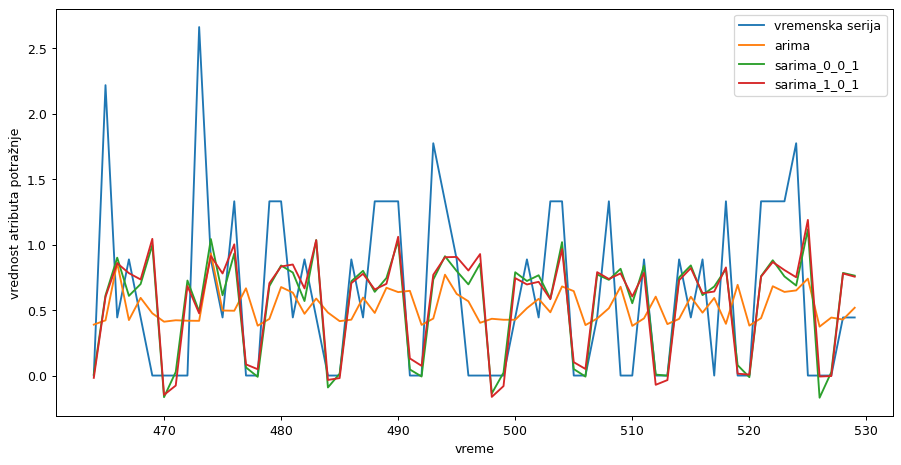

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(actual['demand_value'], label='vremenska serija')
plt.plot(final_df_2021_04_01['model__arima_0_0_1__T1'], label='arima')
plt.plot(final_df_2021_04_01['model__sarima_0_0_1_1_0_1_7__T1'], label='sarima_0_0_1'),
plt.plot(final_df_2021_04_01['model__sarima_1_0_1_1_0_1_7__T1'], label='sarima_1_0_1')

plt.xlabel("vreme")
plt.ylabel("vrednost atributa potražnje")
plt.legend()
plt.show()